In [1]:
%matplotlib inline

In [2]:
import itertools
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.fft import rfft, rfftfreq
from scipy.signal import argrelmin
from tqdm.notebook import tqdm

In [3]:
from physics_utils import constants, pauli

constants.m_star = 0.026
constants.c_k = (
    constants.hbar ** 2
    / (2 * constants.m_star * constants.m_e)
    / (constants.eV * 1e-3 * 1e-18)
)

In [4]:
plt.style.use("sans_style.mplstyle")

line_colors = [
    "xkcd:bright sky blue",
    "xkcd:cobalt blue",
    "xkcd:bright purple",
    "xkcd:bordeaux",
]

pd_cmap = mpl.colors.ListedColormap(
    ["darkorange", "gold", "lightgreen", "lightseagreen"]
)

plt.close("all")

In [5]:
simname = "theta_C_vs_mu_C_Lb5Vb2"

ds = xr.open_dataset(f"./output/{simname}/{simname}.nc")

ws = ds["ws"]
a_N, b_N, theta_N, k = ws.shape

a_ax = ds.coords["a"].to_numpy()
b_ax = ds.coords["b"].to_numpy()

a, b = np.meshgrid(a_ax, b_ax, indexing="ij")

theta_ax = ds.coords["theta"].to_numpy()
theta_N = theta_ax.shape[0]
dtheta = theta_ax[1] - theta_ax[0]

In [6]:
# a_label = r"$h_\mathrm{all} / \Delta$"
# a_label = r"$h_\mathrm{lat} / \Delta$"
# a_label = r"$\alpha_\mathrm{lat}$ (meV nm)"
# a_label = r"$V_\mathrm{barr} / \Delta$"
# a_label = r"$\mu_\mathrm{lat} / \Delta$"
# a_label = "$L_{C}$ (nm)"
a_label = r"$\theta_c$"

b_label = r"$\mu_C / \Delta$"
# b_label = r"$h_C / \Delta$"
# b_label = r"$h_\mathrm{lat} / \Delta$"
# b_label = r"$\alpha_C$ (meV nm)"
# b_label = r"$\alpha$ (meV nm)"
# b_label = r"$h_{R, y} / \Delta$"
# b_label = r"$\beta_x$ (meV nm)"

Delta_0 = 0.250
I_0 = 2 * constants.e * Delta_0 / constants.hbar * constants.meV * 1e9

a_scale = 1 # Delta_0
b_scale = Delta_0
e_scale = Delta_0
i_scale = I_0

In [7]:
os.makedirs(f"./output/{simname}/plots/", exist_ok=True)

# Preliminary checks

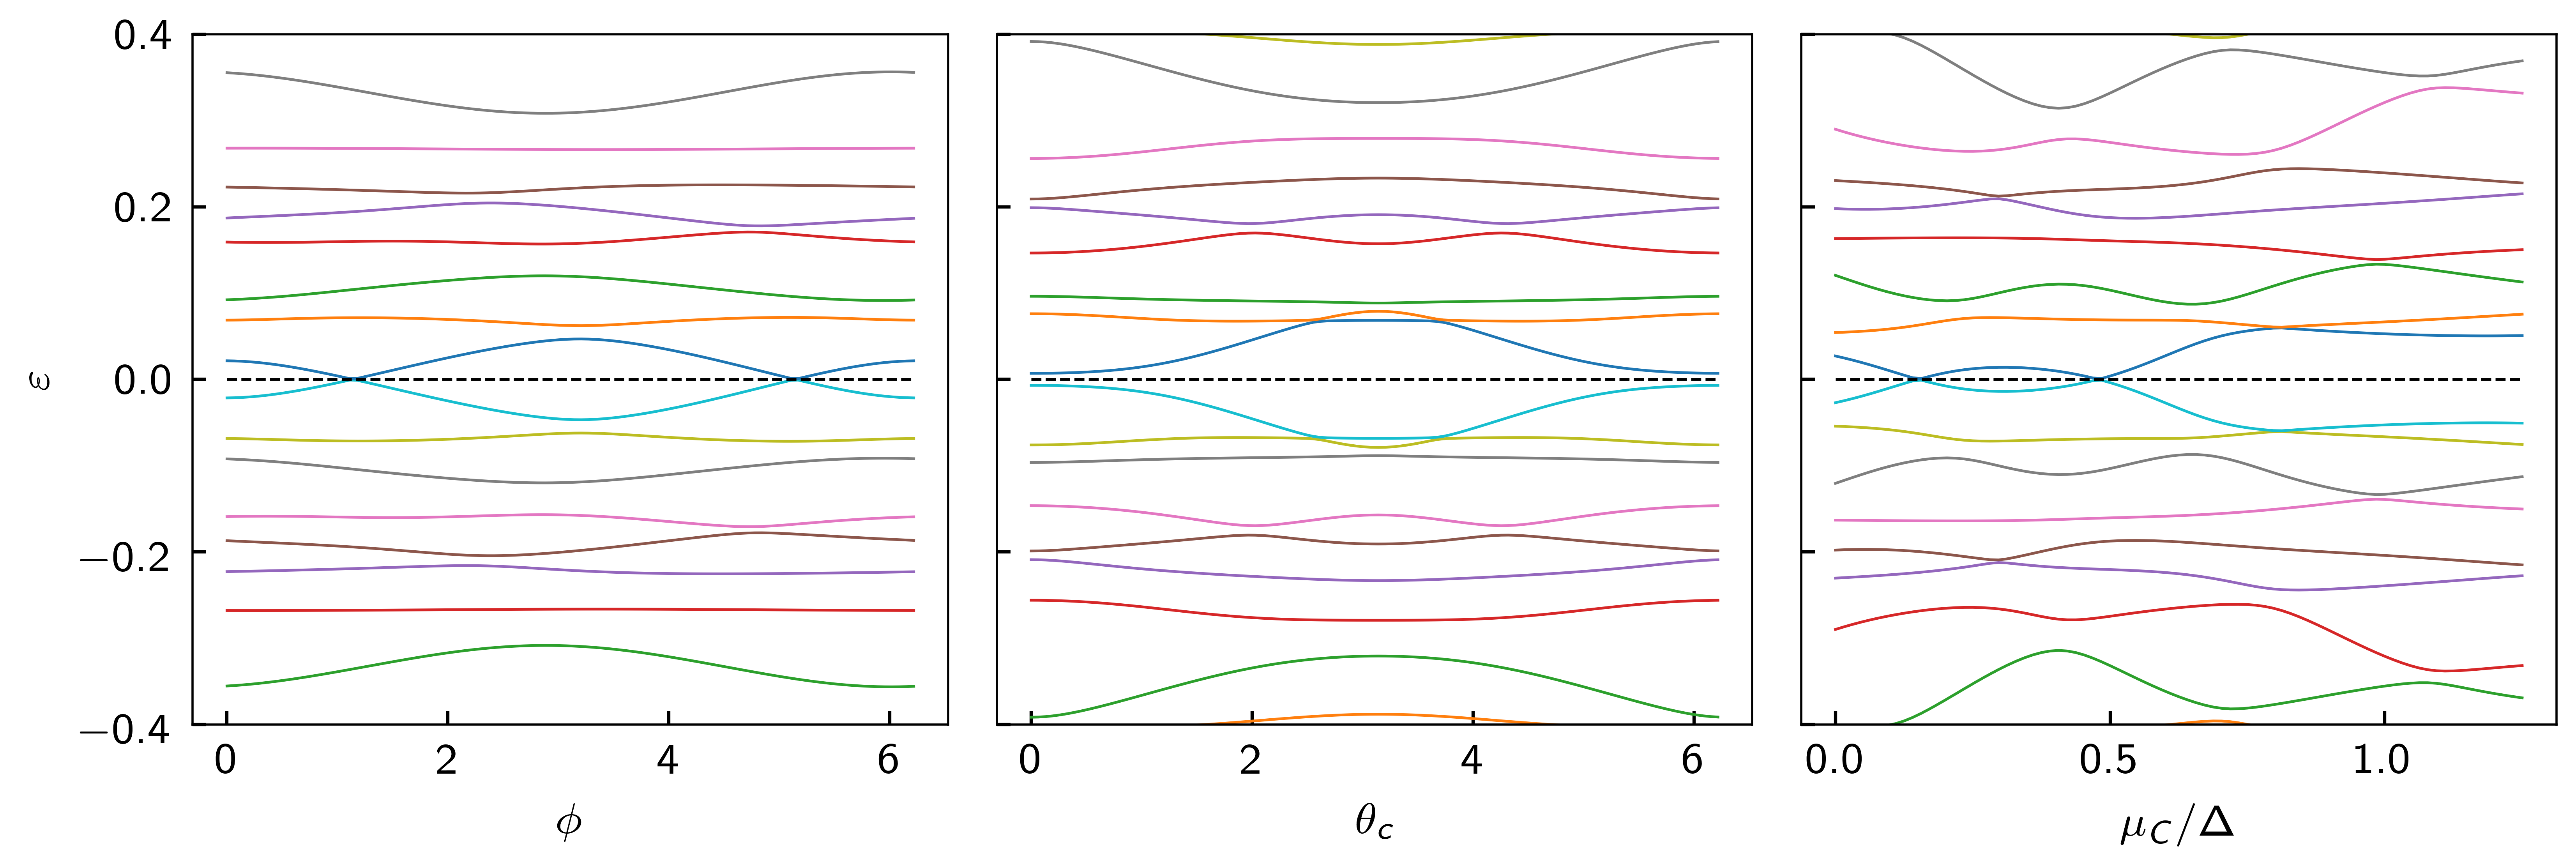

In [8]:
# Check the spectrum
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3, figsize=(2 * 3.375, 0.7 * 3.375), sharey=True
)

a_idx = 20
b_idx = 37
t_idx = 0

for n in range(k):
    ax1.plot(theta_ax, ws[a_idx, b_idx, :, n], "-", markersize=0.5, label=rf"{n}")
    ax2.plot(a_ax, ws[:, b_idx, t_idx, n], "-", markersize=0.5, label=rf"{n}")
    ax3.plot(b_ax, ws[a_idx, :, t_idx, n], "-", markersize=0.5, label=rf"{n}")

ax1.plot(theta_ax, theta_ax * 0, "k--")
ax2.plot(a_ax, a_ax * 0, "k--")
ax3.plot(b_ax, b_ax * 0, "k--")

ax1.set_xlabel(r"$\phi$")
ax2.set_xlabel(a_label)
ax3.set_xlabel(b_label)

ax1.set_ylim(-0.4, 0.4)
ax1.set_ylabel(r"$\varepsilon$")
fig.tight_layout()
fig.savefig(f"./output/{simname}/plots/{simname}_spectrum.svg")

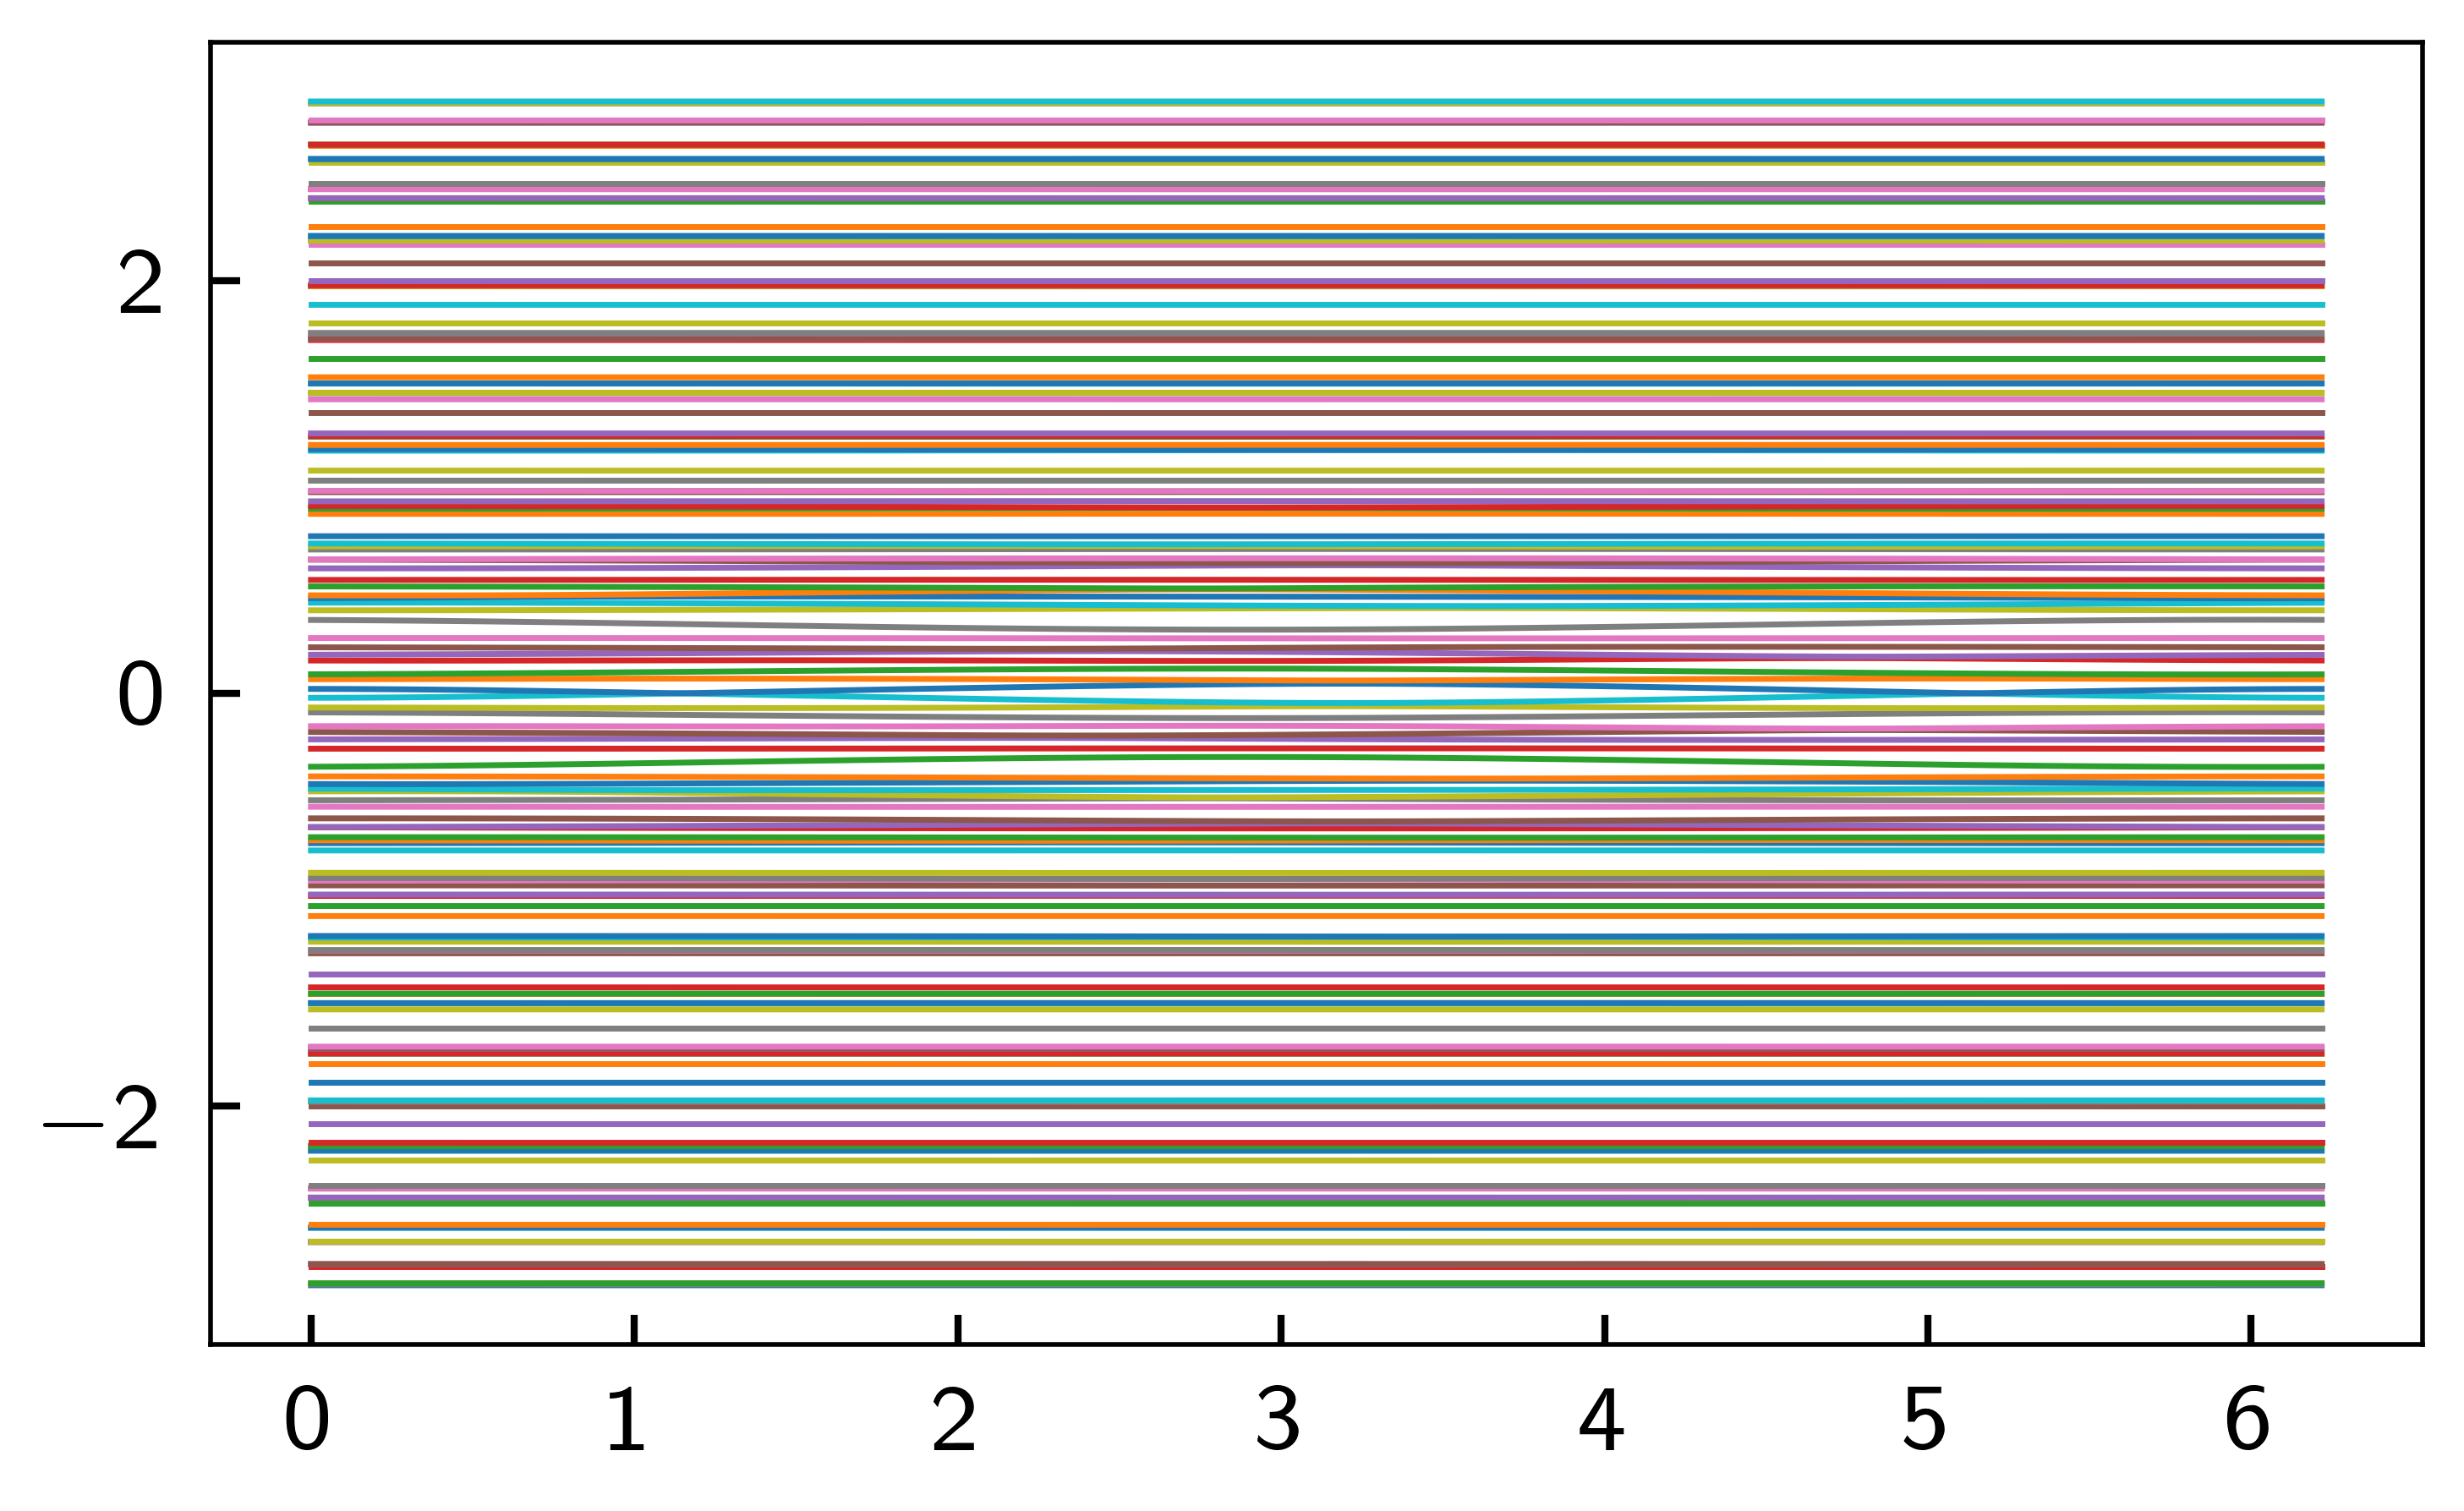

In [9]:
for n in range(k):
    plt.plot(theta_ax, ws[a_idx, b_idx, :, n], "-", markersize=0.5, label=rf"{n}")

In [10]:
# Calculate Andreev DOS and spectral current
eps_N = 1001
eps_ax = np.linspace(-2, 2, eps_N)
dos = np.zeros((a_N, theta_N, eps_N))

Gamma = 0.02

_ws = ws[:, b_idx].to_numpy()

for n in tqdm(range(k)):
    dos += (
        1
        / np.sqrt(2 * np.pi * Gamma)
        * np.exp(
            -(
                ((eps_ax[np.newaxis, np.newaxis, :] - _ws[..., n, np.newaxis]) / Gamma)
                ** 2
            )
        )
    )

ie = (np.roll(dos, -1, axis=-2) - dos) / dtheta
ie *= 2 * constants.e / constants.hbar * constants.meV * 1e9

  0%|          | 0/160 [00:00<?, ?it/s]

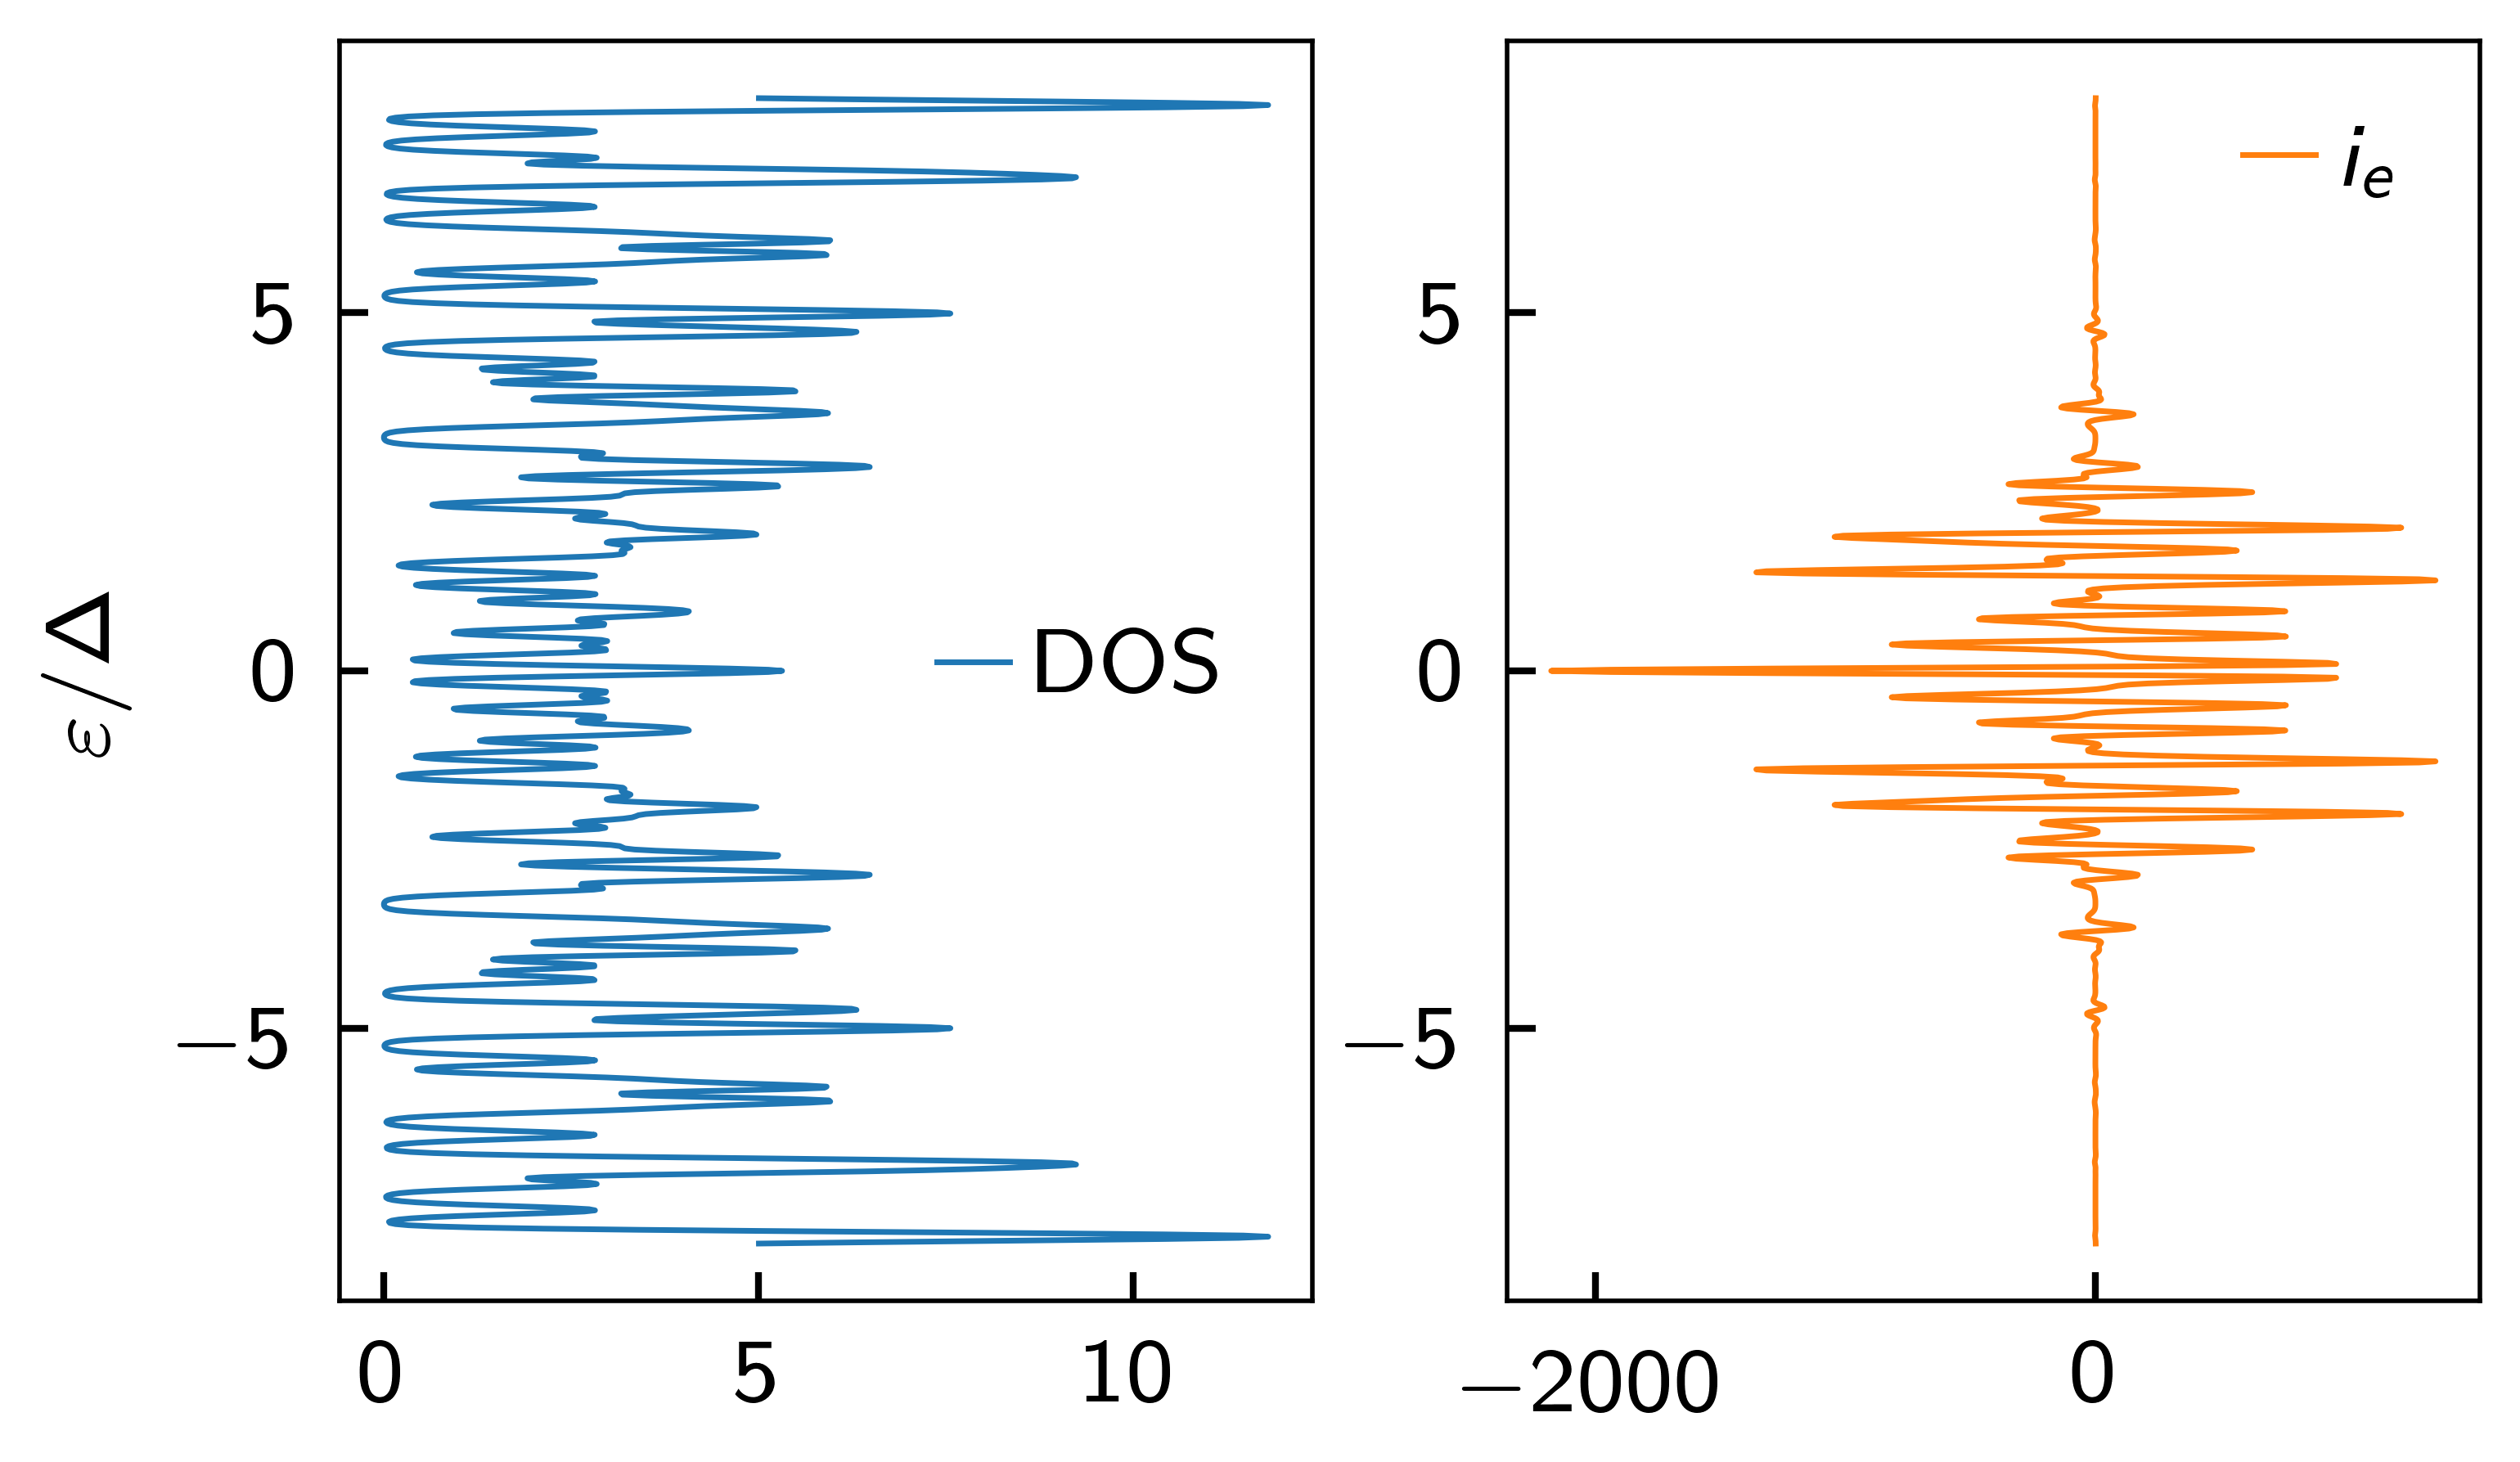

In [11]:
a_idx = 20
b_idx = 20

fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.plot(dos[a_idx, b_idx], eps_ax / Delta_0, "C0-", label="DOS")
ax2.plot(ie[a_idx, b_idx], eps_ax / Delta_0, "C1-", label=r"$i_e$")
ax1.set_ylabel(r"$\varepsilon / \Delta$")
ax1.legend()
ax2.legend()

# Calculate free energy and current

In [12]:
def logcosh(x):
    ax = np.abs(x)
    return ax if ax > 2 else np.log(2 * np.cosh(x))


logcosh = np.frompyfunc(logcosh, 1, 1)

In [13]:
# Set the temperature
T = 20e-3  # mK

# lc = np.abs(ws / (2 * constants.k_B * T))
lc = logcosh(ws / (2 * constants.k_B * T))
F = -(constants.k_B * T) * np.sum(lc, axis=-1)

emin = -np.min(np.abs(ws), axis=-1)

F.name = "F"
emin.name = "emin"

In [14]:
arm = argrelmin(F.to_numpy(), axis=-1, order=1, mode="wrap")

mins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]
vmins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]

for n in range(len(arm[0])):
    i = arm[0][n]
    j = arm[1][n]
    n = arm[2][n]

    mins_list[i][j].append(theta_ax[n])
    vmins_list[i][j].append(F[i, j, n])

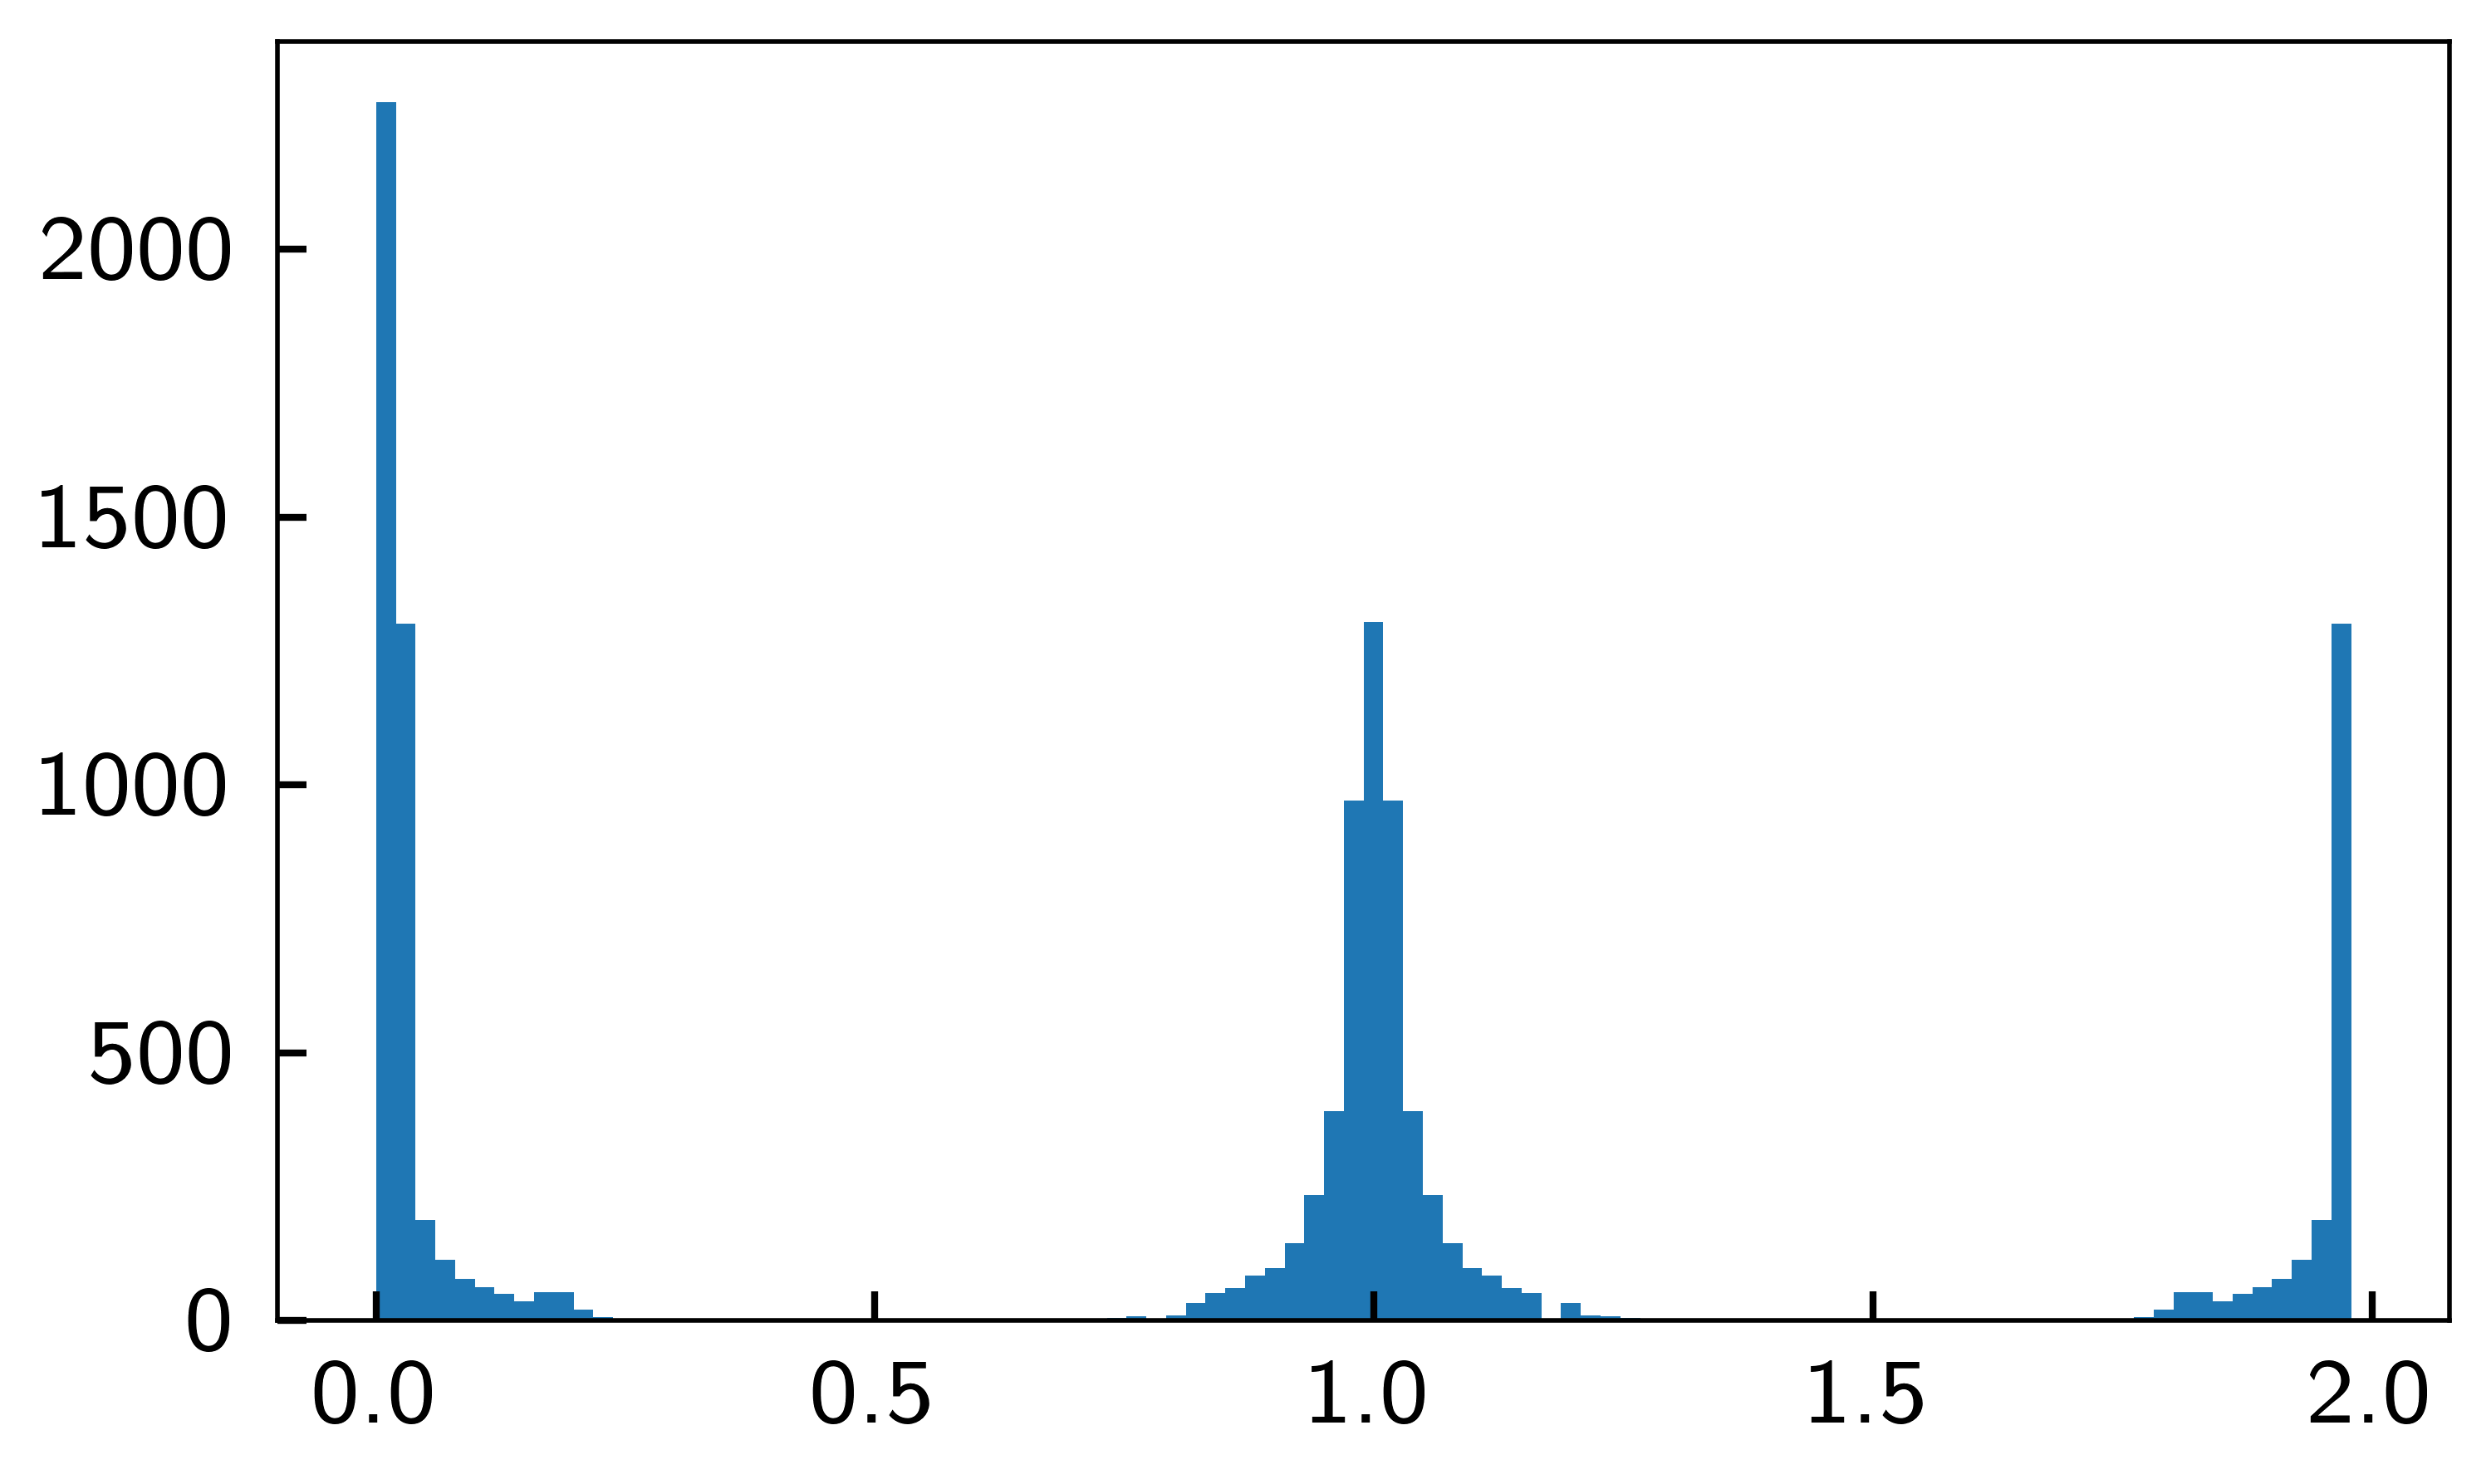

In [15]:
mins_flat = list(itertools.chain(*mins_list))
mins_flat = list(itertools.chain(*mins_flat))
fig, ax = plt.subplots()
ax.hist(np.array(mins_flat) / np.pi, bins=100);

In [16]:
pd = np.zeros((a_N, b_N)) * np.nan
pdm = np.zeros((a_N, b_N)) * np.nan
pdf = np.zeros((a_N, b_N)) * np.nan

for i, j in tqdm(np.ndindex(a_N, b_N), total=a_N * b_N):

    if len(mins_list[i][j]) == 1:
        if abs(mins_list[i][j][0]) < abs(mins_list[i][j][0] - np.pi):
            pd[i][j] = 0
        else:
            pd[i][j] = 3.14

    elif len(mins_list[i][j]) == 2:
        vmmin = np.argmin(vmins_list[i][j])
        mmin = mins_list[i][j][vmmin]

        if abs(mmin) < abs(mmin - np.pi):
            pd[i][j] = 3.14 / 3
        else:
            pd[i][j] = 2 * 3.14 / 3

    else:
        pd[i][j] = np.mean(mins_list[i][j])
    pdm[i][j] = np.mean(mins_list[i][j])
    pdf[i][j] = mins_list[i][j][0] if len(mins_list[i][j])>0 else np.nan

  0%|          | 0/7776 [00:00<?, ?it/s]

In [17]:
_I = (np.roll(F.to_numpy(), -1, axis=-1) - F.to_numpy()) / dtheta
_I *= 2 * constants.e / constants.hbar * constants.meV * 1e9

_I_c = np.zeros((a_N, b_N))
for i, j in np.ndindex(a_N, b_N):
    _I_c[i, j] = _I[i, j, np.argmax(np.abs(_I[i, j, : theta_N // 2]), axis=-1)]

I = xr.zeros_like(F)
I[:, :, :] = _I

I_c = xr.DataArray(_I_c, dims=("a", "b"), coords={"a": a_ax, "b": b_ax})

eta = (abs(I.max("theta")) - abs(I.min("theta")))/(abs(I.max("theta")) + abs(I.min("theta"))).to_numpy()

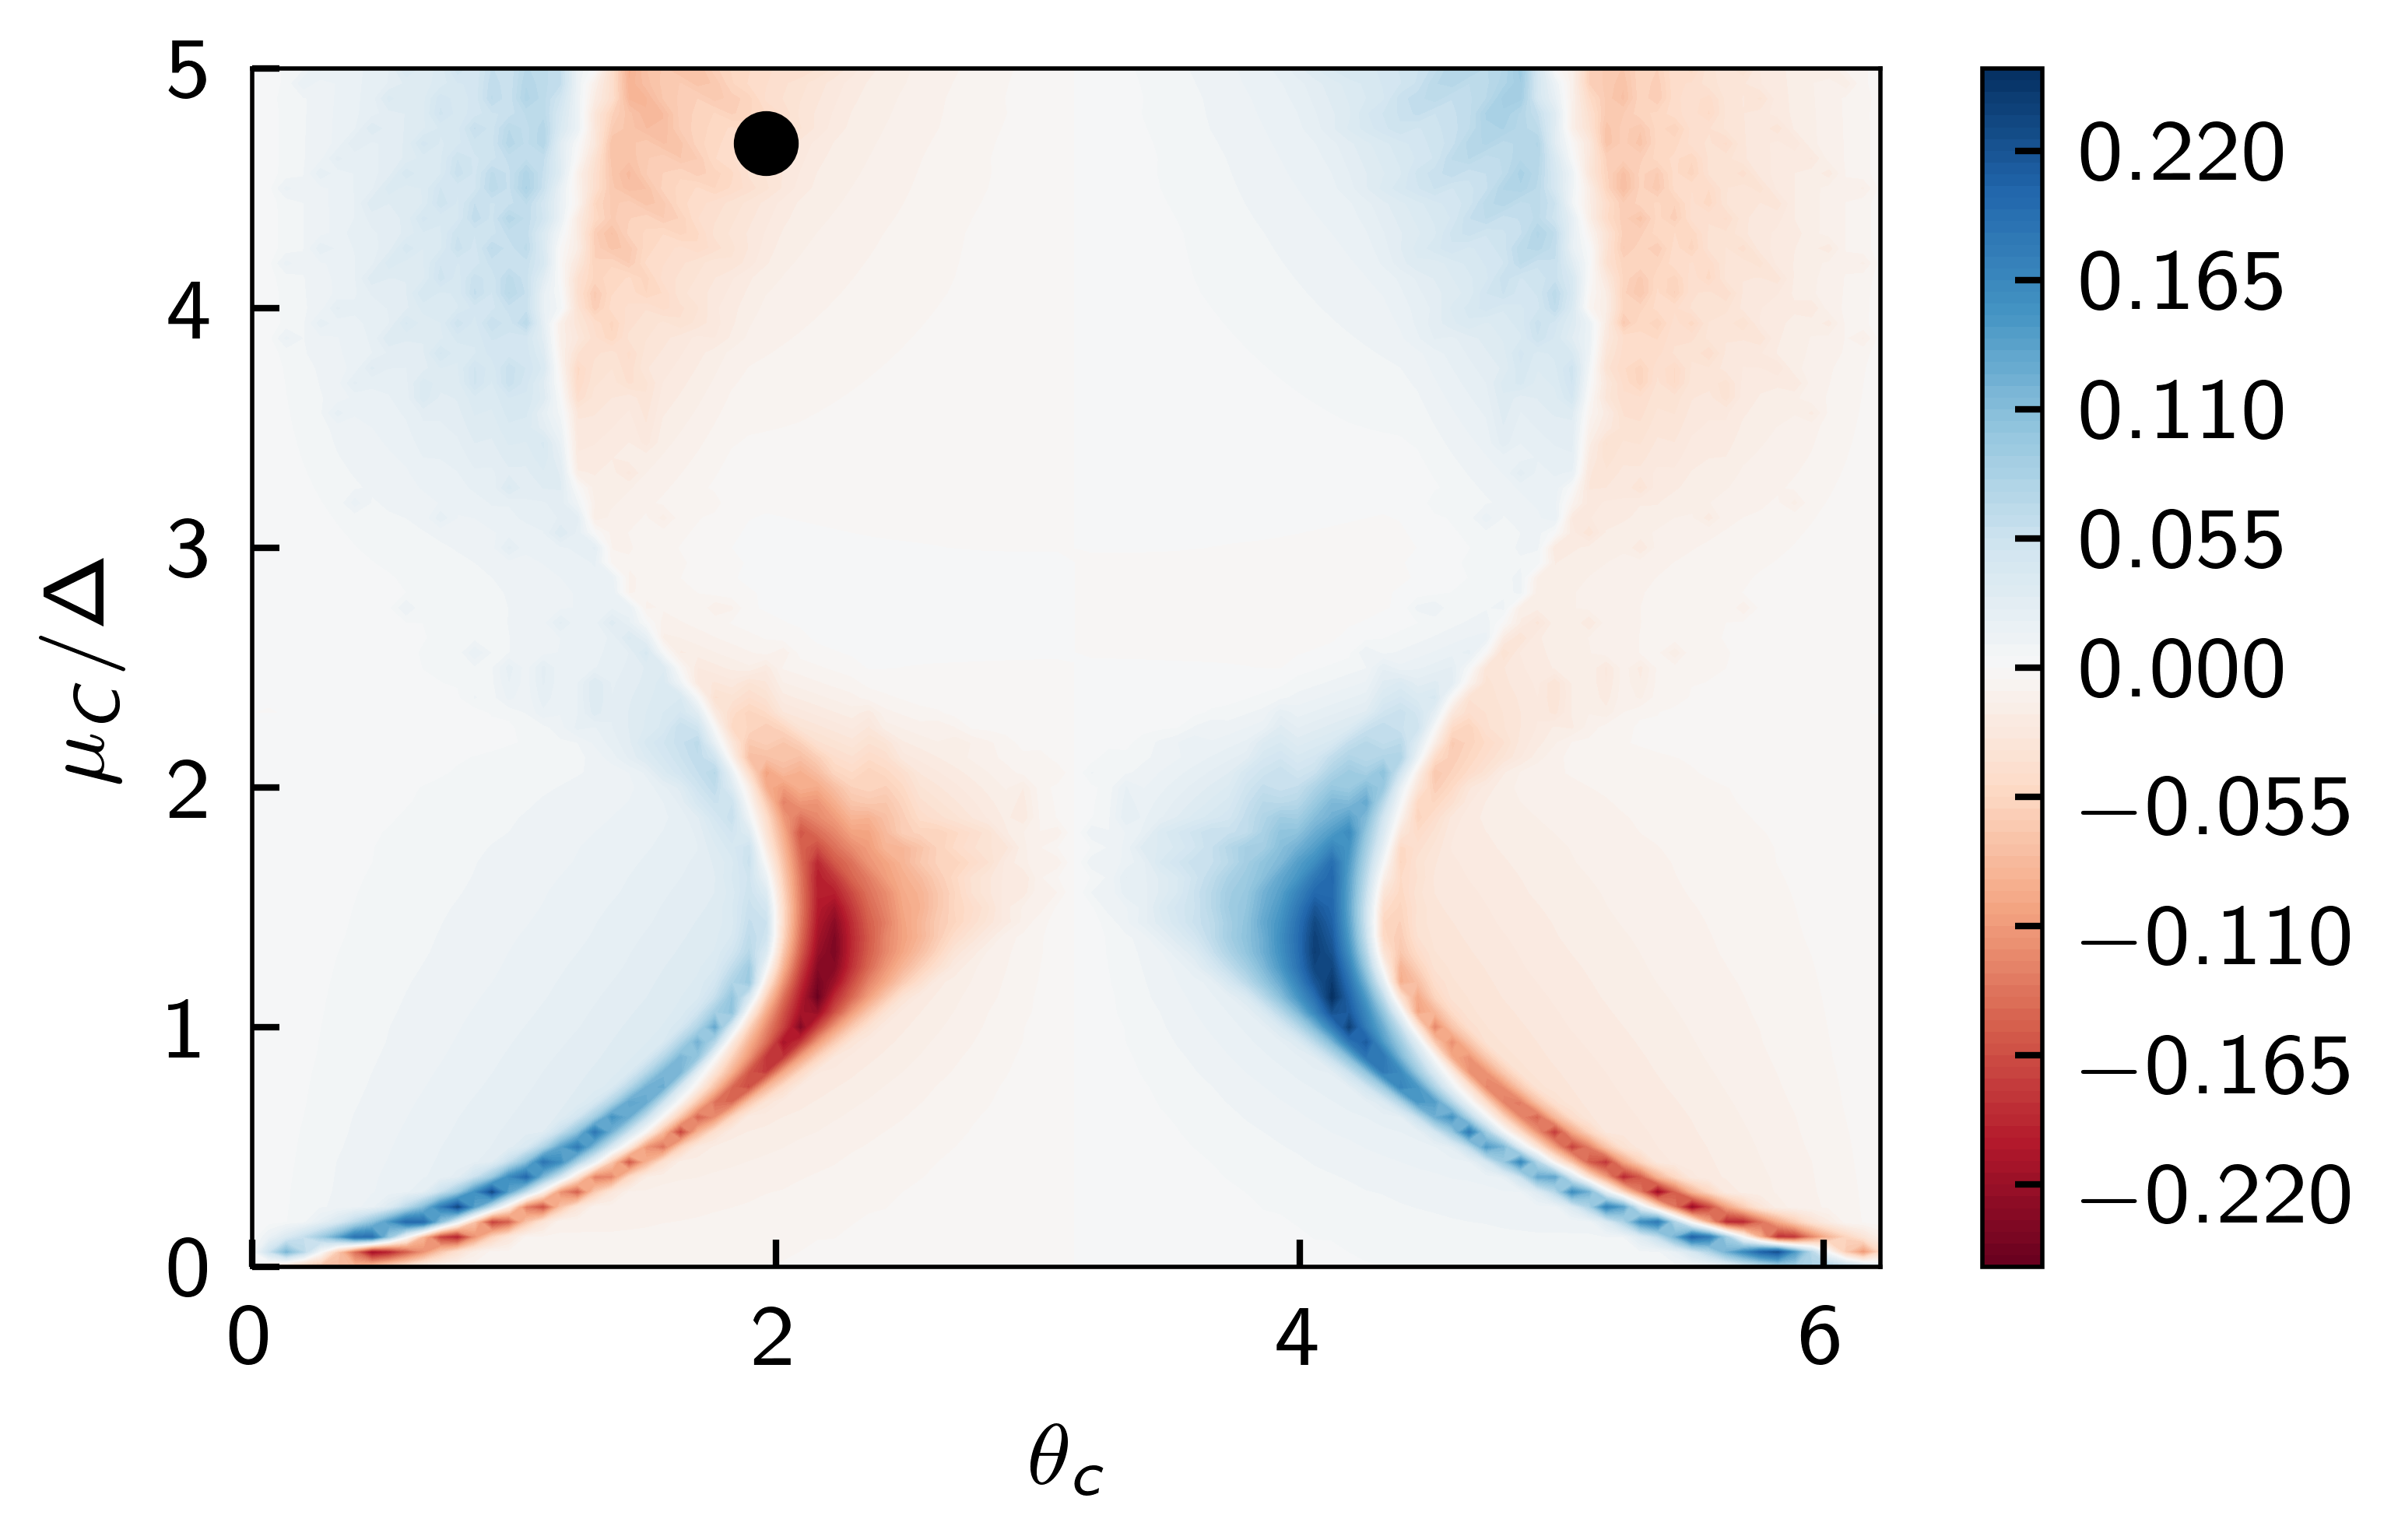

In [18]:


fig, ax = plt.subplots()
im = ax.contourf(a/a_scale, b/b_scale, eta, cmap="RdBu", norm=mpl.colors.CenteredNorm(0), levels=101)
fig.colorbar(im)
ax.set_xlabel(a_label)
ax.set_ylabel(b_label)
a_idx = 30
b_idx = 75
plt.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='k')

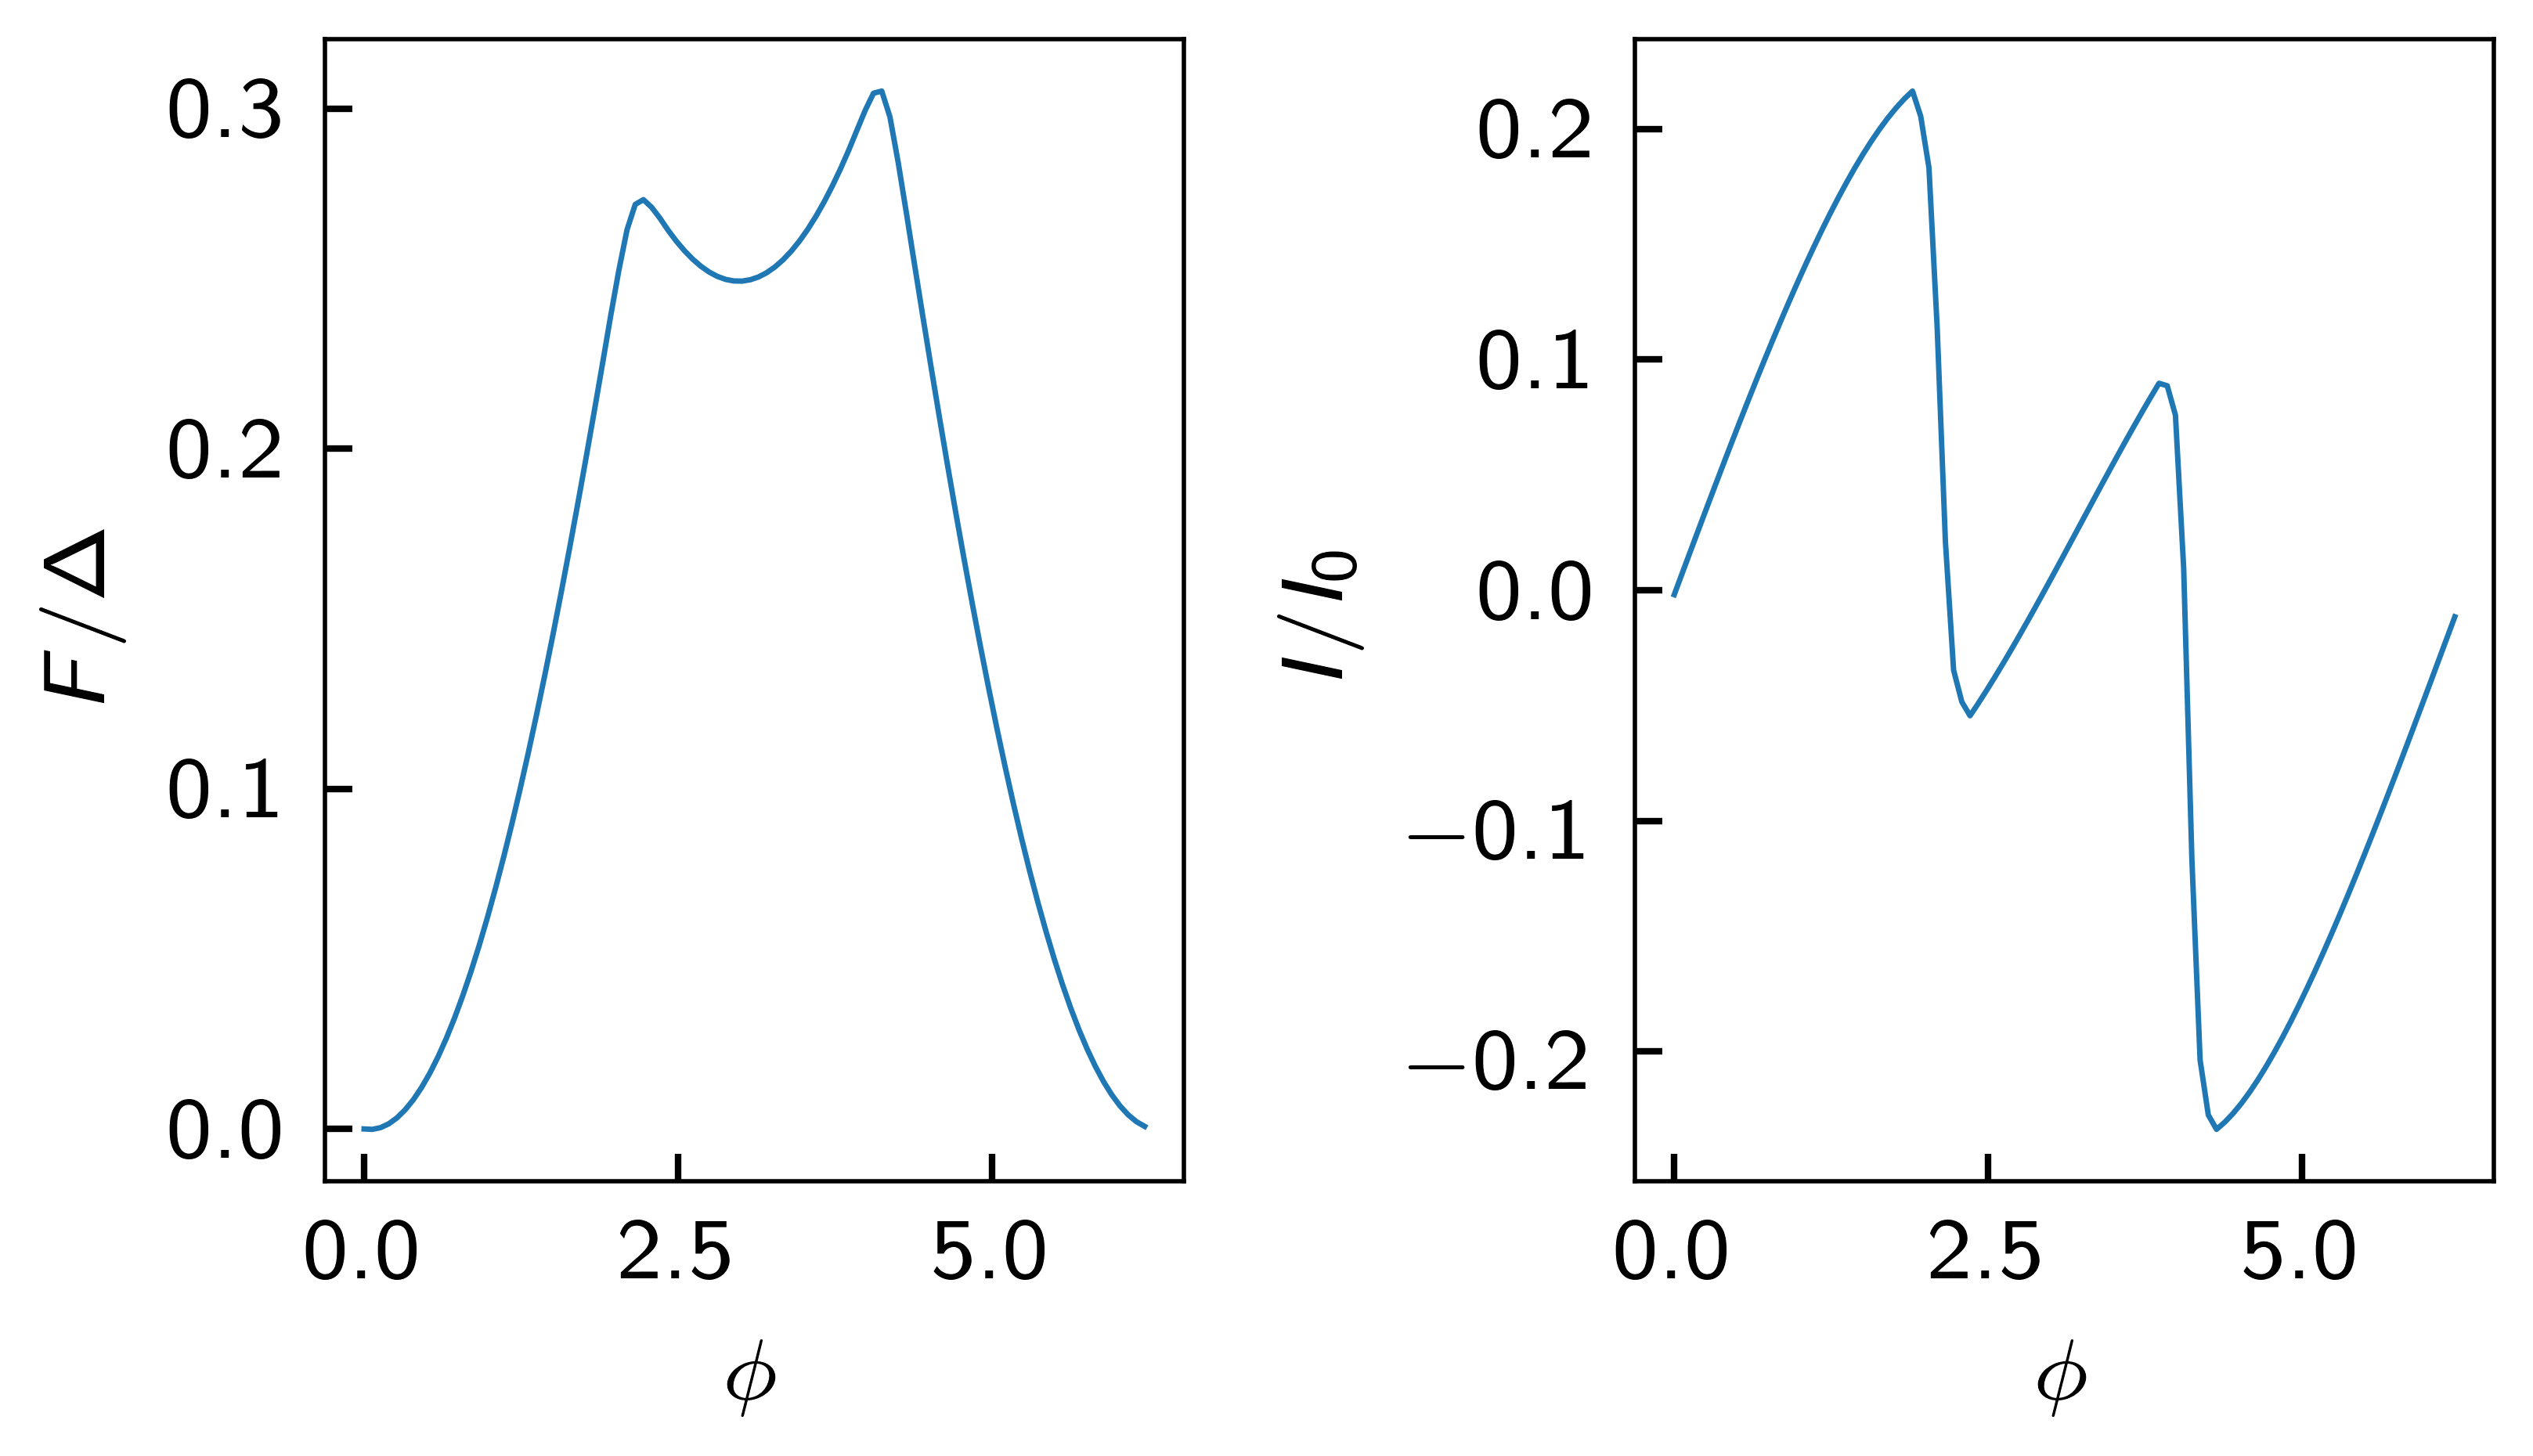

In [19]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(theta_ax, (F[a_idx, b_idx]-F[a_idx, b_idx, 0])/Delta_0, '-')
ax[1].plot(theta_ax, I[a_idx, b_idx]/I_0, '-')


ax[0].set_xlabel(r"$\phi$")
ax[1].set_xlabel(r"$\phi$")

ax[0].set_ylabel(r"$F/\Delta$")
ax[1].set_ylabel(r"$I/I_0$")

fig.tight_layout()

In [20]:
N = F.shape[-1]

ks = rfftfreq(N, 1 / N)
F_k = 2.0 / N * rfft(F)
cF_k = +F_k.real
sF_k = -F_k.imag
aF_k = np.abs(F_k)

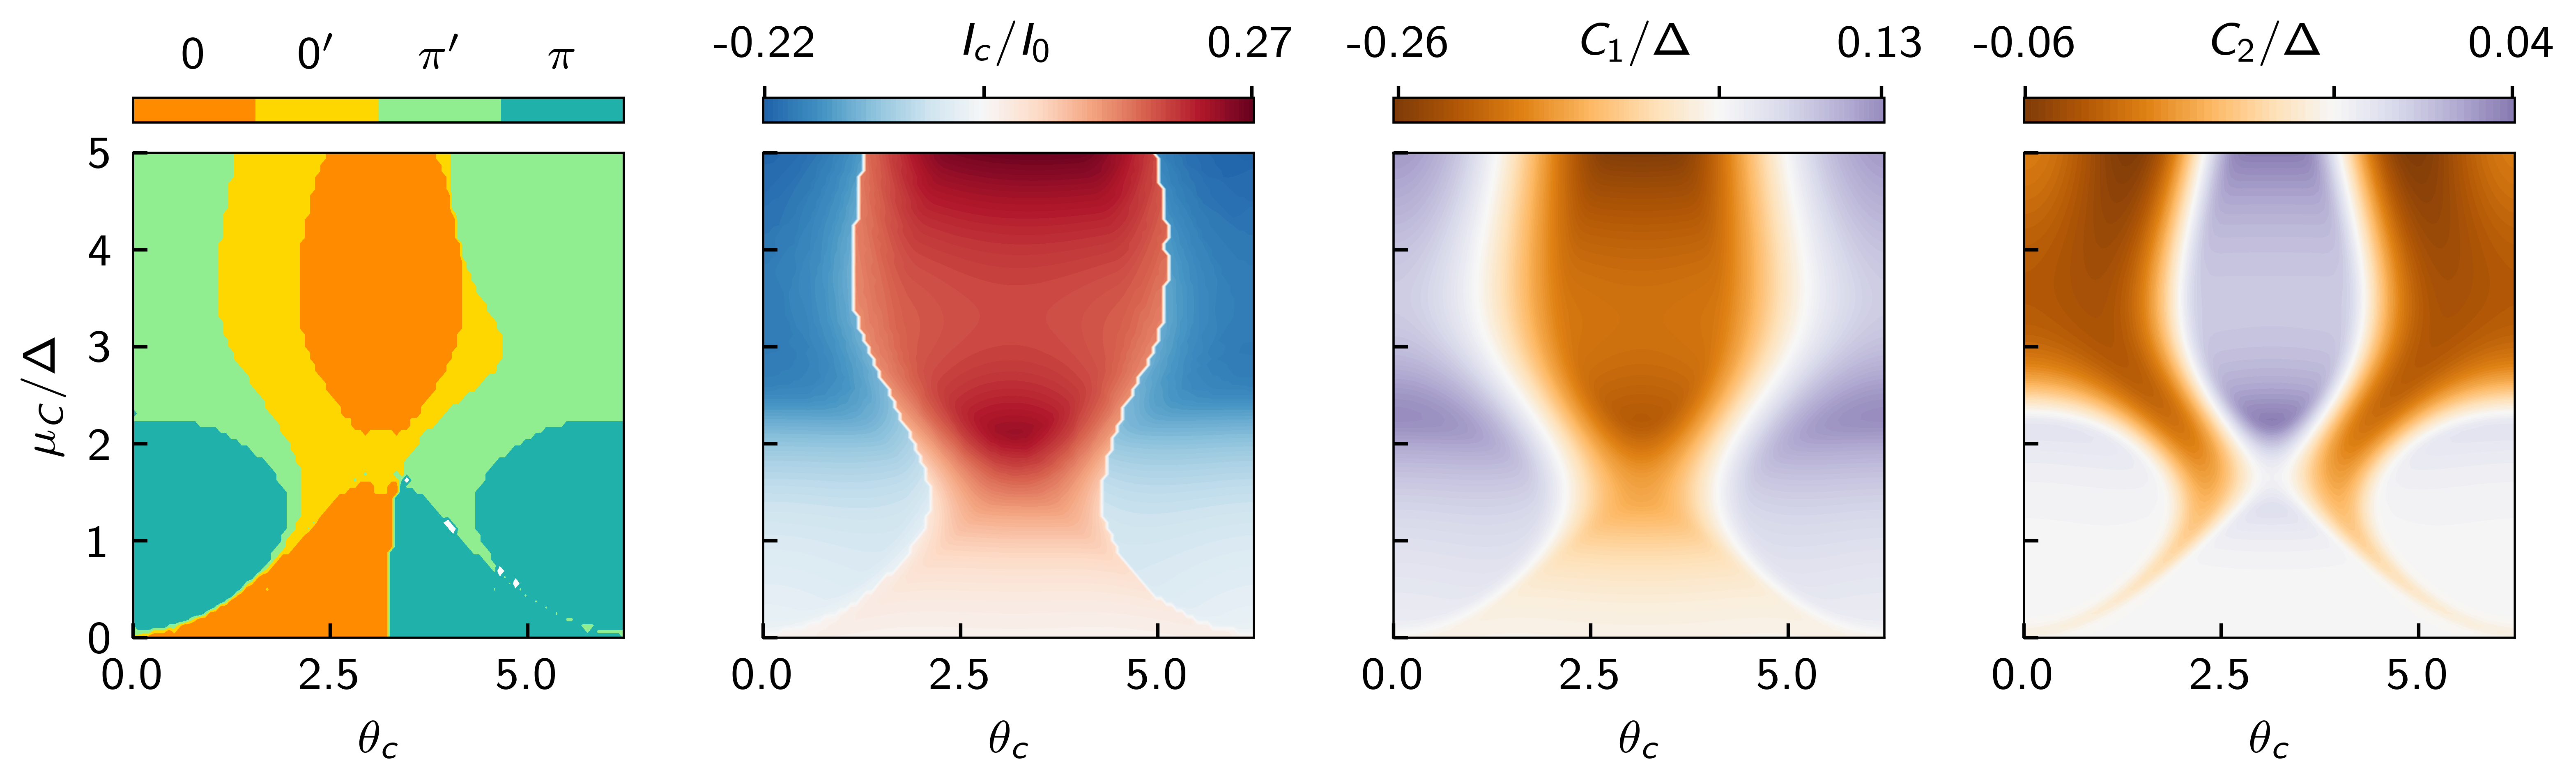

In [21]:
# 0-PI plot 1C page

gap_inv_lines = False

x_coords = np.random.randint(0, 30, size=(4))
y_coords = np.random.randint(0, 31, size=(4))
coords = np.zeros((4, 2))
coords[:, 0] = a_ax[x_coords] / a_scale
coords[:, 1] = b_ax[y_coords] / b_scale

fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    dpi=1000, figsize=(3.375 * 1.9, 3.375 * 0.6), ncols=4, nrows=1
)

levels = np.linspace(0, 3.2, 5)


im = ax1.contourf(a / a_scale, b / b_scale, pd, levels=levels, cmap=pd_cmap, zorder=-30)

ax1.set_xlim(a_ax.min() / a_scale, a_ax.max() / a_scale)
ax1.set_ylim(b_ax.min() / b_scale, b_ax.max() / b_scale)

ax1.set_xlabel(a_label)
# ax1.set_xticklabels([])
ax1.set_ylabel(b_label)
# ax1.set_yticklabels([])

cbar = fig.colorbar(im, ax=ax1, location="top")
cbar.set_ticks([1 / 8 * 3.2, 3 / 8 * 3.2, 5 / 8 * 3.2, 7 / 8 * 3.2])
cbar.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
cbar.ax.tick_params(length=0)

ax1.set_rasterization_zorder(-10)

#####

im = ax2.contourf(
    a / a_scale,
    b / b_scale,
    I_c / i_scale,
    levels=100,
    norm=mpl.colors.CenteredNorm(),
    cmap="RdBu_r",
    zorder=-30,
)
cbar2 = fig.colorbar(im, ax=ax2, format="%3.2f", location="top")

ax2.set_xlabel(a_label)
# ax2.set_xticklabels([])
# ax2.set_ylabel(b_label)
ax2.set_yticklabels([])


if gap_inv_lines:
    ax2.hlines(
        [-1, +1],
        a_ax.min() / a_scale,
        a_ax.max() / a_scale,
        color="k",
        linestyles="dashed",
        linewidths=0.75,
    )
    ax2.vlines(
        [-1, +1],
        b_ax.min() / b_scale,
        b_ax.max() / b_scale,
        color="k",
        linestyles="dashed",
        linewidths=0.75,
    )

cbar2.set_ticks([I_c.min() / I_0, 0, I_c.max() / I_0], labels=[f"{I_c.min() / I_0:3.2f}", "", f"{I_c.max() / I_0:3.2f}"])
cbar2.ax.tick_params(length=2, direction="out")
cbar2.set_label(r"$I_c / I_0$", labelpad=-5)

ax2.set_xlim(a_ax.min() / a_scale, a_ax.max() / a_scale)
ax2.set_ylim(b_ax.min() / b_scale, b_ax.max() / b_scale)


ax2.set_rasterization_zorder(-10)

################################

ax3.set_rasterization_zorder(0)

ax3.set_xlabel(a_label)
# ax3.set_xticklabels([])
# ax3.set_ylabel(b_label)
ax3.set_yticklabels([])

im3 = ax3.contourf(
    a / a_scale,
    b / b_scale,
    cF_k[:, :, 1] / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr",
    zorder=-30,
)
cbar3 = fig.colorbar(im3, ax=ax3, format="%3.2f", location="top")
cbar3.set_ticks(
    [np.min(cF_k[:, :, 1] / Delta_0), 0, np.max(cF_k[:, :, 1] / Delta_0)],
    labels=[
        f"{np.min(cF_k[:, :, 1] / Delta_0):3.2f}",
        "",
        f"{np.max(cF_k[:, :, 1] / Delta_0):3.2f}",
    ],
)
cbar3.ax.tick_params(length=2, direction="out")
cbar3.set_label(r"$C_1 / \Delta$", labelpad=-5)
##################################################

ax4.set_rasterization_zorder(0)

ax4.set_xlabel(a_label)
# ax4.set_xticklabels([])
# ax4.set_ylabel(b_label)
ax4.set_yticklabels([])

im4 = ax4.contourf(
    a / a_scale,
    b / b_scale,
    cF_k[:, :, 2] / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr",
    zorder=-30,
)
cbar4 = fig.colorbar(im4, ax=ax4, format="%3.2f", location="top")
cbar4.set_ticks(
    [np.min(cF_k[:, :, 2] / Delta_0), 0, np.max(cF_k[:, :, 2] / Delta_0)],
    labels=[
        f"{np.min(cF_k[:, :, 2] / Delta_0):3.2f}",
        "",
        f"{np.max(cF_k[:, :, 2] / Delta_0):3.2f}",
    ],
)
cbar4.ax.tick_params(length=2, direction="out")
cbar4.set_label(r"$C_2 / \Delta$", labelpad=-5)

fig.tight_layout()
fig.savefig(f"./output/{simname}/plots/{simname}_0PI_fullpage.svg")

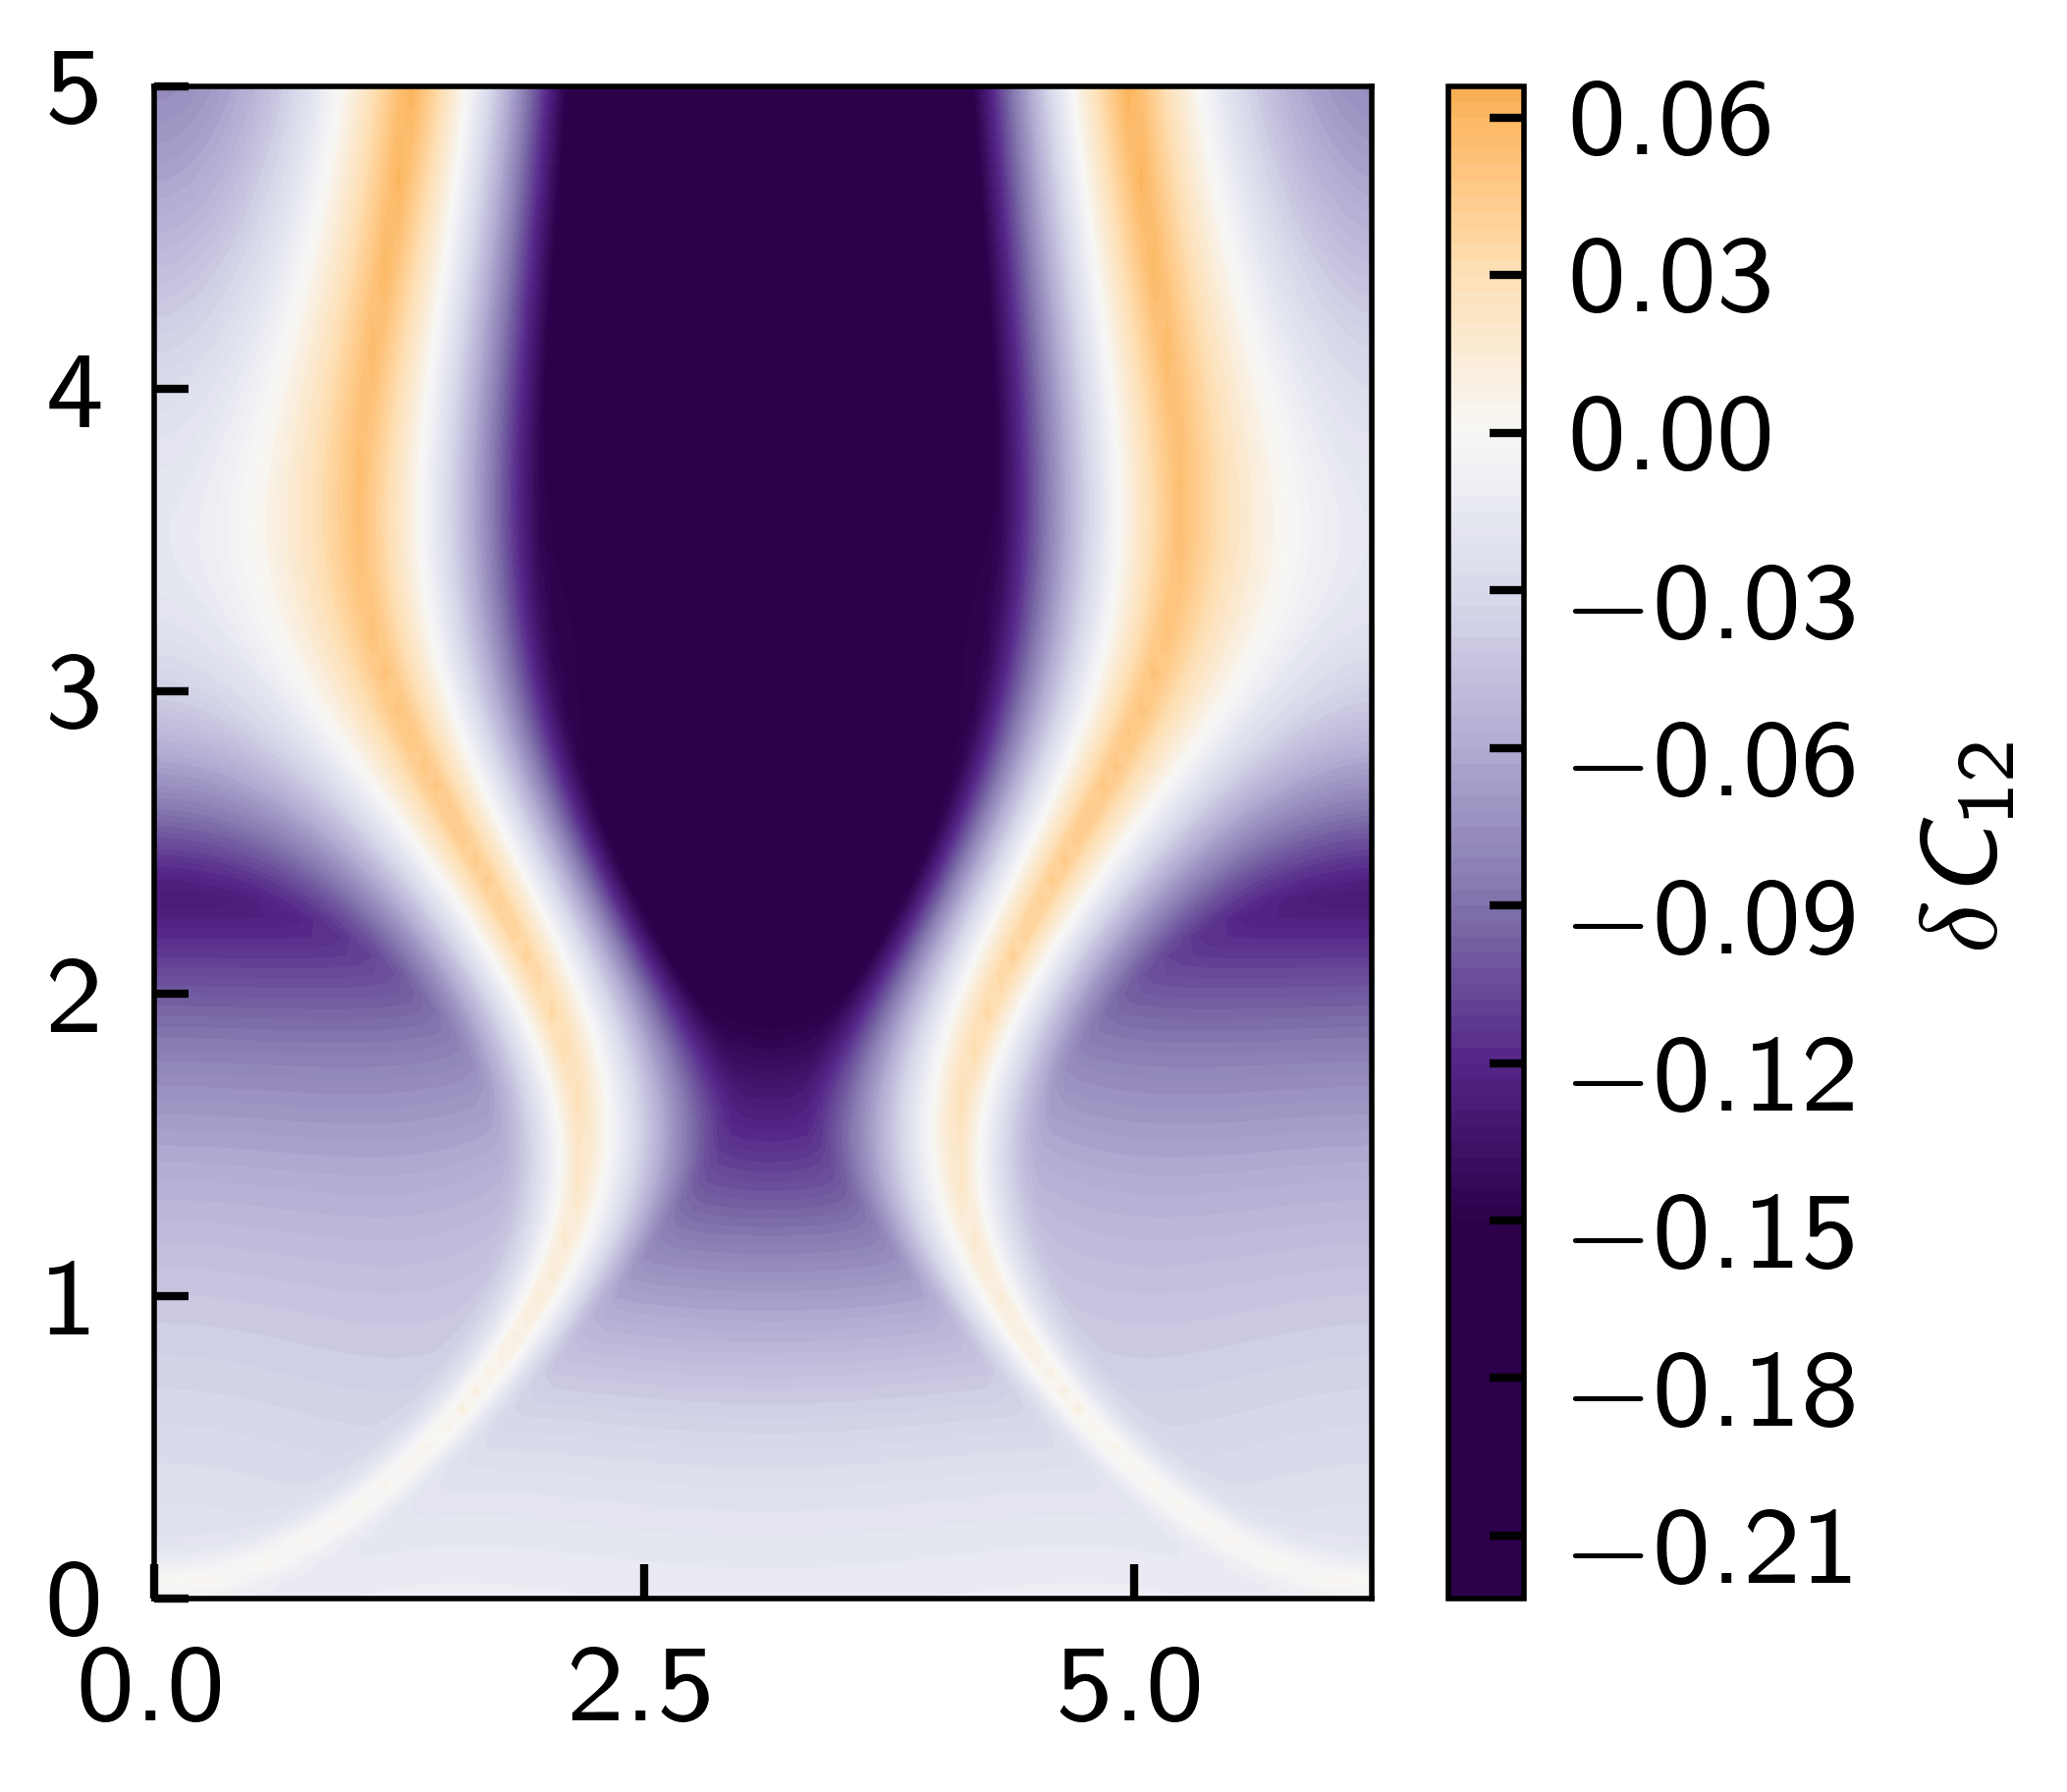

In [22]:
fig, ax = plt.subplots(figsize=(2, 2))
im = ax.contourf(
    a / a_scale,
    b / b_scale,
    (abs(cF_k[:, :, 2]) - abs(cF_k[:, :, 1])) / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0, 0.15),
    cmap="PuOr_r",
    zorder=-30,
)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel(r"$\delta C_{12}$")
fig.savefig(f"./output/{simname}/plots/{simname}_dC12.svg")

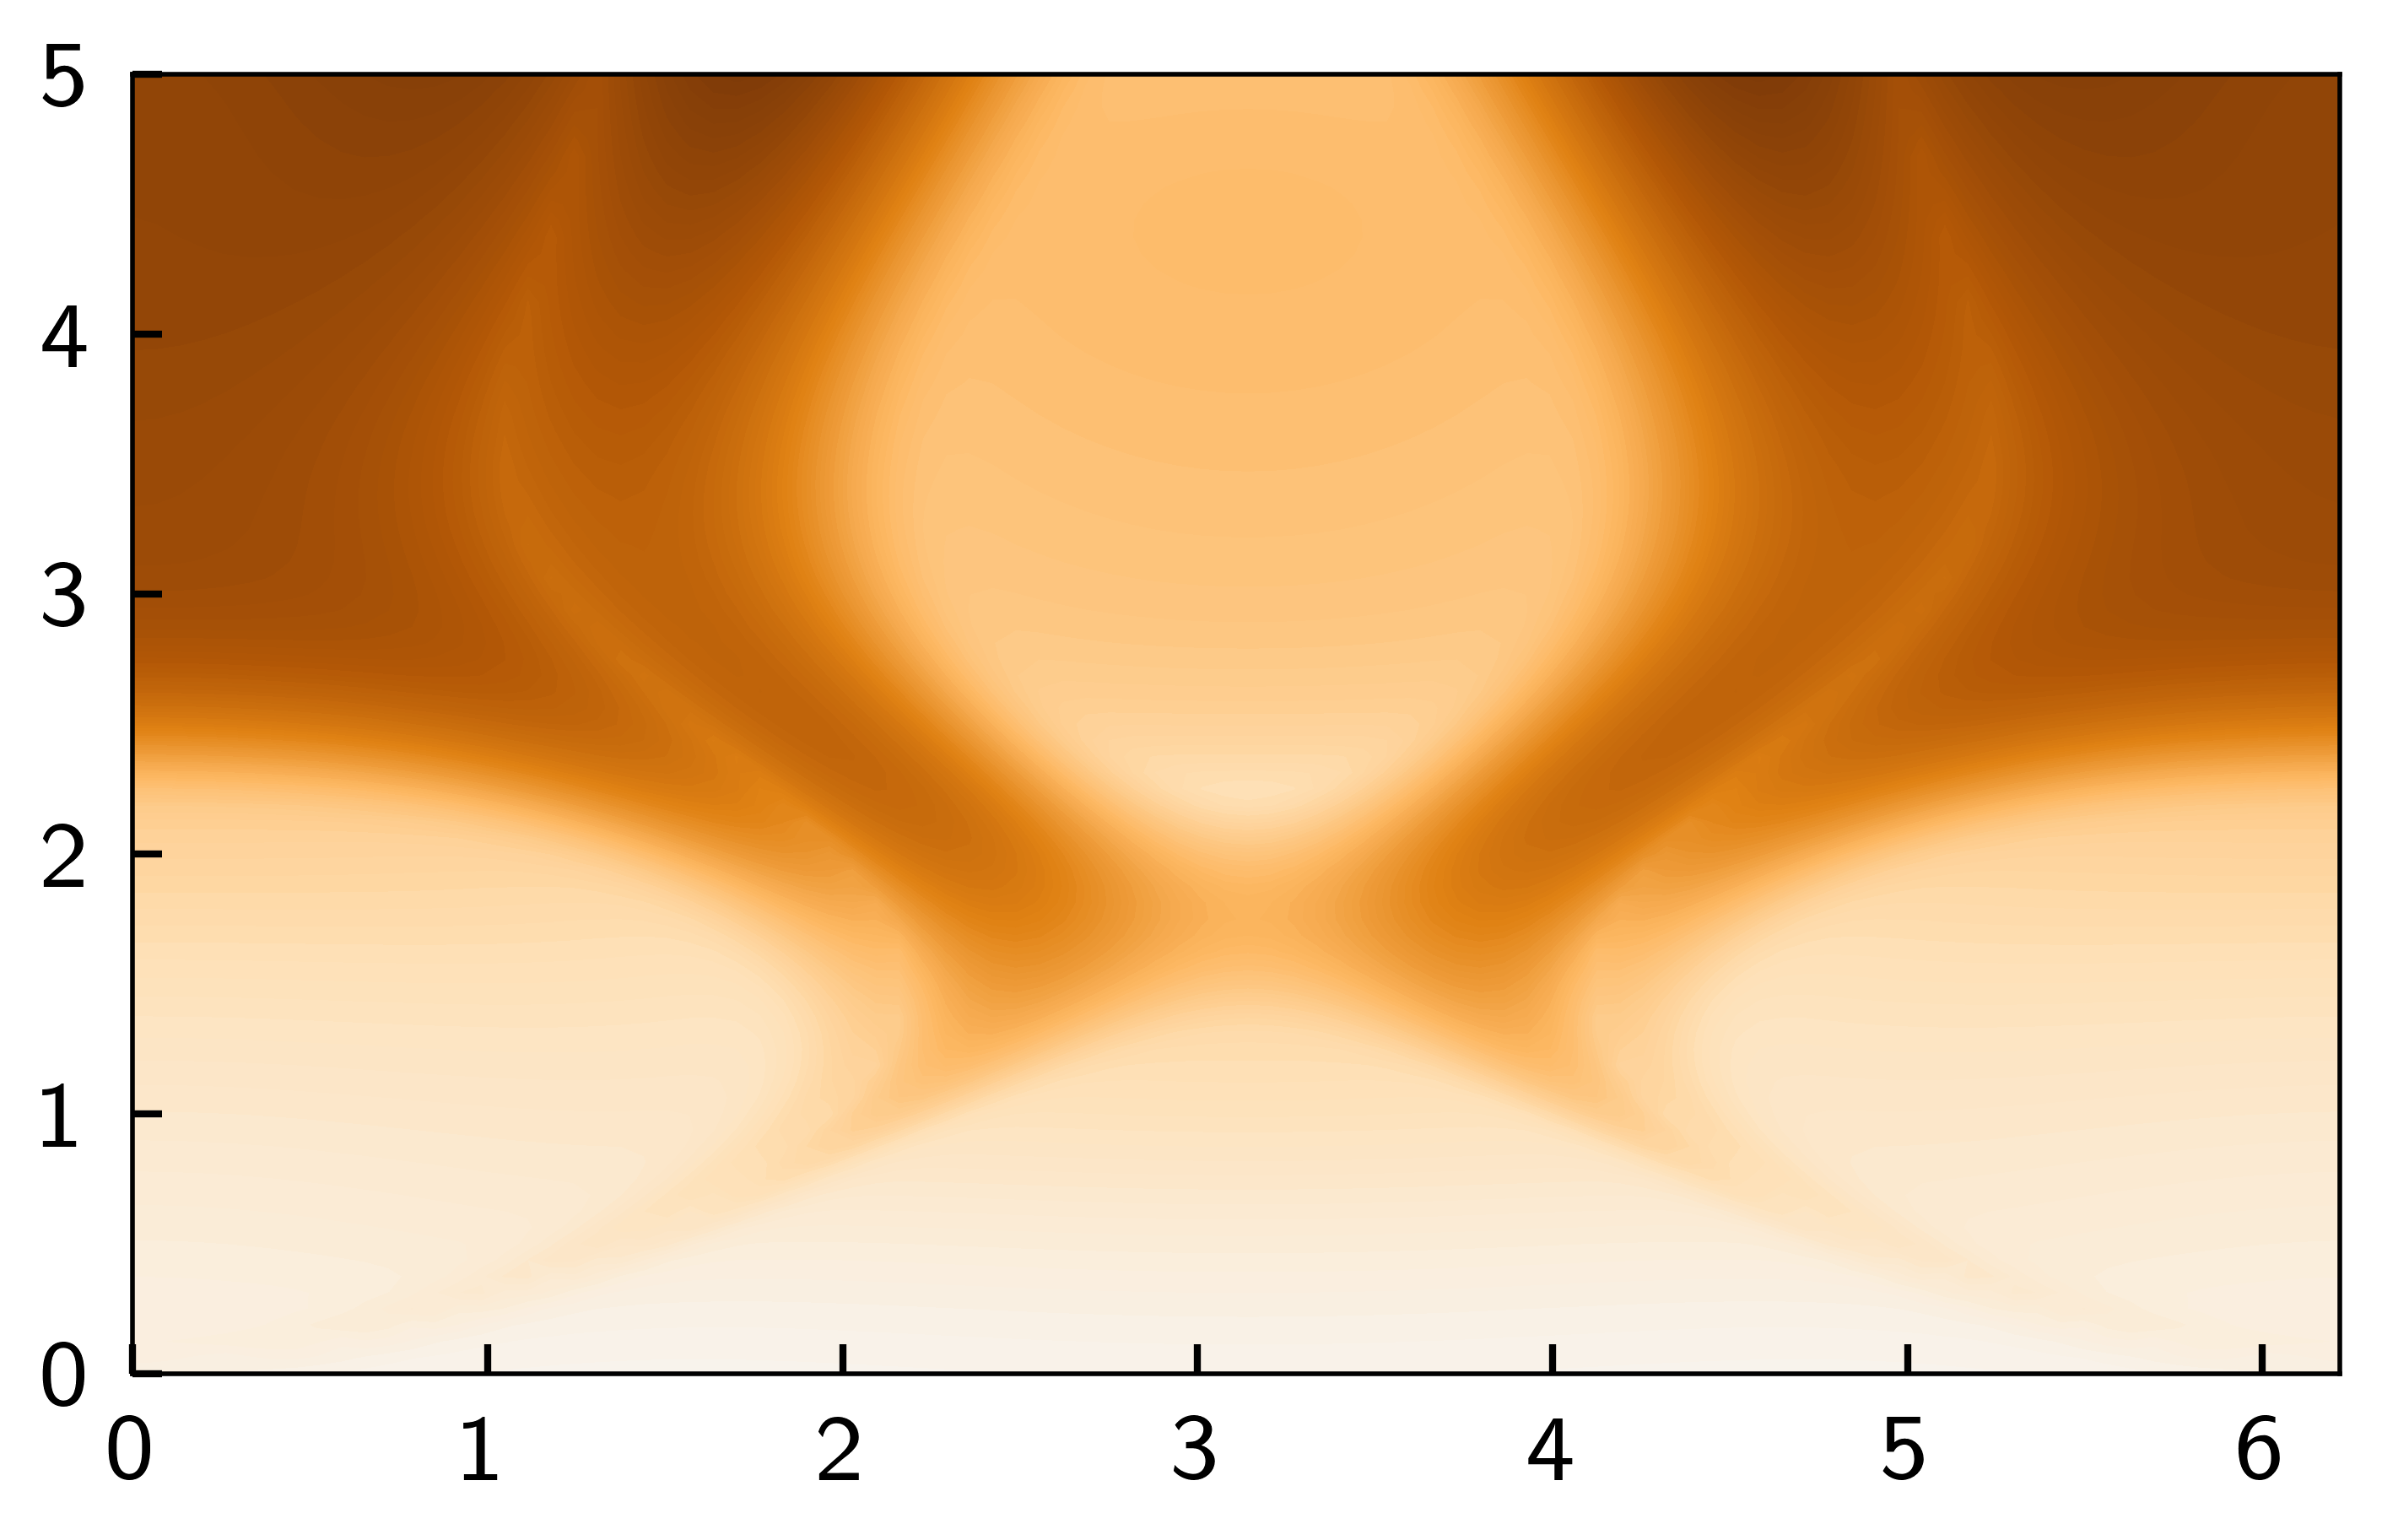

In [23]:
plt.contourf(
    a / a_scale,
    b / b_scale,
    (np.abs(cF_k[:, :, 1]) - 4 * cF_k[:, :, 2]) / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr_r",
    zorder=-30,
)

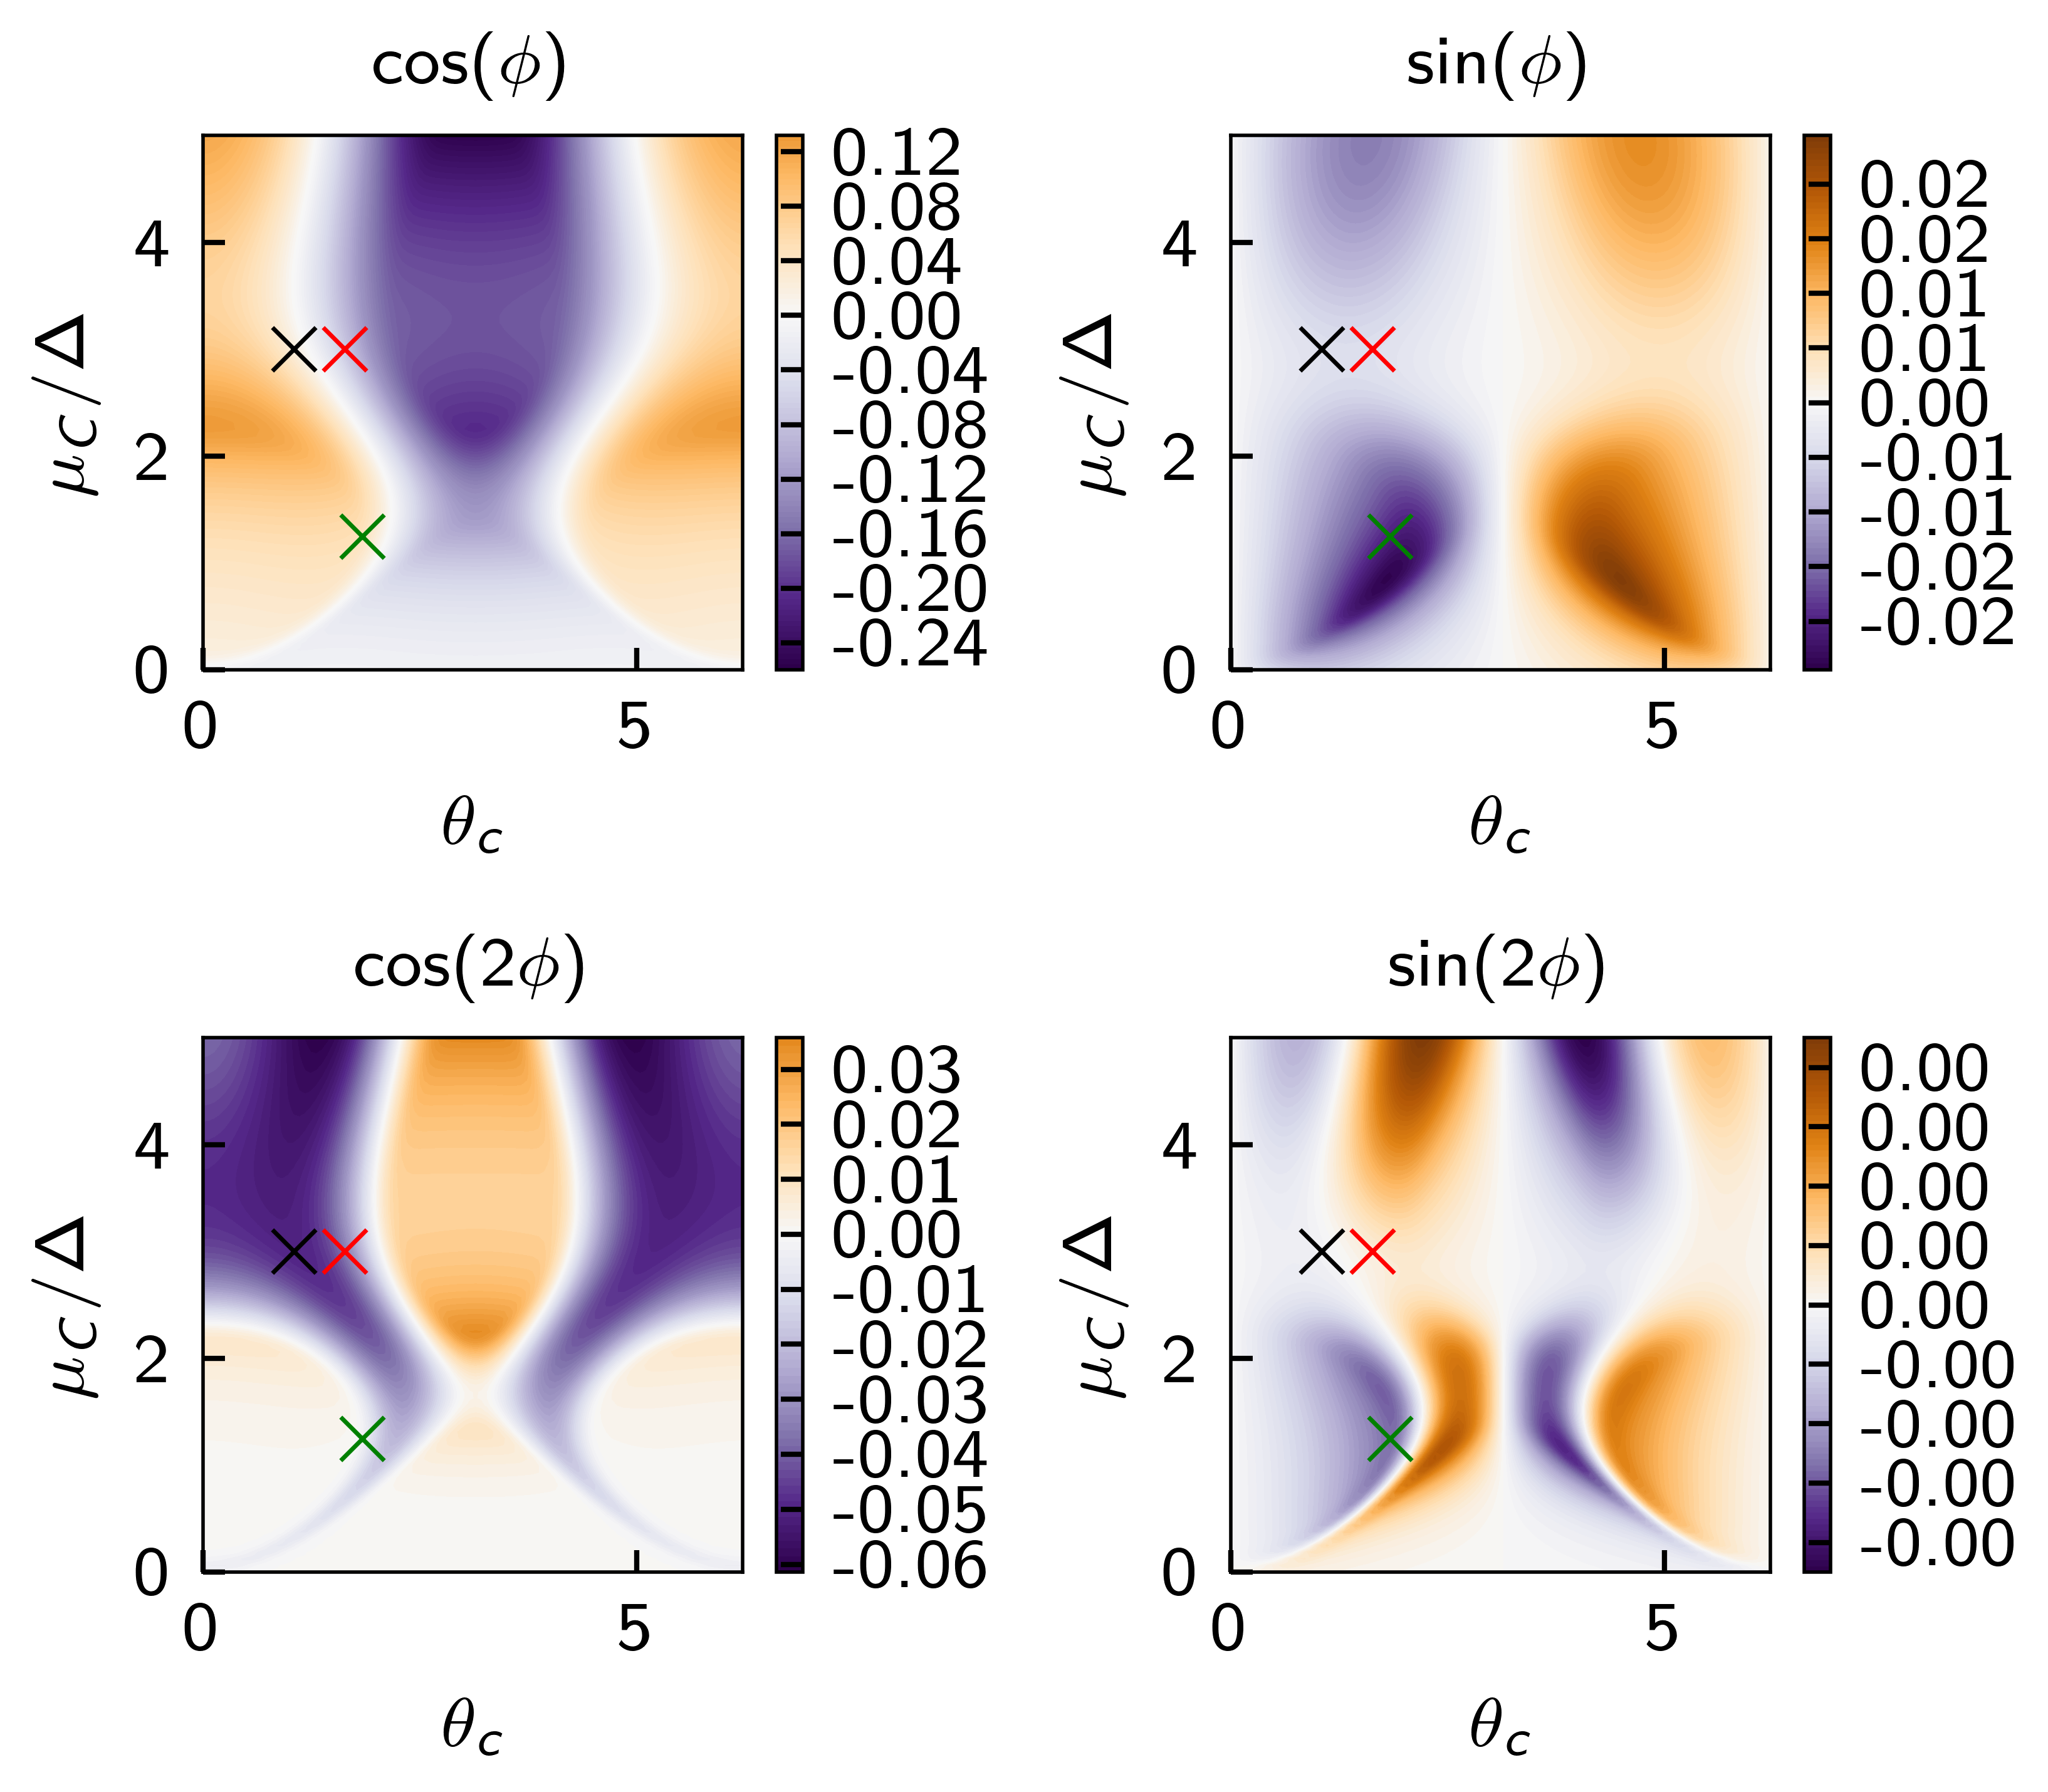

In [24]:
what1 = cF_k[..., 1] / Delta_0
what2 = sF_k[..., 1] / Delta_0
what3 = cF_k[..., 2] / Delta_0
what4 = sF_k[..., 2] / Delta_0
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(3.4, 3))

ax1.set_rasterization_zorder(0)
ax2.set_rasterization_zorder(0)
ax3.set_rasterization_zorder(0)
ax4.set_rasterization_zorder(0)

ax1.set_xlabel(a_label)
ax1.set_ylabel(b_label)

ax2.set_xlabel(a_label)
ax2.set_ylabel(b_label)

ax3.set_xlabel(a_label)
ax3.set_ylabel(b_label)

ax4.set_xlabel(a_label)
ax4.set_ylabel(b_label)

im1 = ax1.contourf(
    a / a_scale,
    b / b_scale,
    what1,
    levels=100,
    cmap="PuOr_r",
    zorder=-30,
    norm=mpl.colors.CenteredNorm(0),
)
fig.colorbar(im1, ax=ax1, format="%3.2f")
ax1.set_title(r"$\cos(\phi)$")

im2 = ax2.contourf(
    a / a_scale,
    b / b_scale,
    what2,
    levels=100,
    cmap="PuOr_r",
    zorder=-30,
    norm=mpl.colors.CenteredNorm(0),
)
fig.colorbar(im2, ax=ax2, format="%3.2f")
ax2.set_title(r"$\sin(\phi)$")

im3 = ax3.contourf(
    a / a_scale,
    b / b_scale,
    what3,
    levels=100,
    cmap="PuOr_r",
    zorder=-30,
    norm=mpl.colors.CenteredNorm(0),
)
fig.colorbar(im3, ax=ax3, format="%3.2f")
ax3.set_title(r"$\cos(2\phi)$")


im4 = ax4.contourf(
    a / a_scale,
    b / b_scale,
    what4,
    levels=100,
    cmap="PuOr_r",
    zorder=-30,
    norm=mpl.colors.CenteredNorm(0),
)
fig.colorbar(im4, ax=ax4, format="%3.2f")
ax4.set_title(r"$\sin(2\phi)$")

# ax3.scatter(coords[:, 0], coords[:, 1], c=colors, zorder=10, marker="x")

# ax1.scatter(0.2, 12.5, c='k')

fig.tight_layout()
fig.savefig(f"./output/{simname}/plots/{simname}_harmonics.svg")


a_idx = 16
b_idx = 48
ax1.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='k', marker='x')
ax2.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='k', marker='x')
ax3.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='k', marker='x')
ax4.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='k', marker='x')

a_idx = 25
b_idx = 48
ax1.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='r', marker='x')
ax2.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='r', marker='x')
ax3.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='r', marker='x')
ax4.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='r', marker='x')


a_idx = 28
b_idx = 20
ax1.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='g', marker='x')
ax2.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='g', marker='x')
ax3.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='g', marker='x')
ax4.scatter(a_ax[a_idx]/a_scale, b_ax[b_idx]/b_scale, c='g', marker='x')

fig.show()

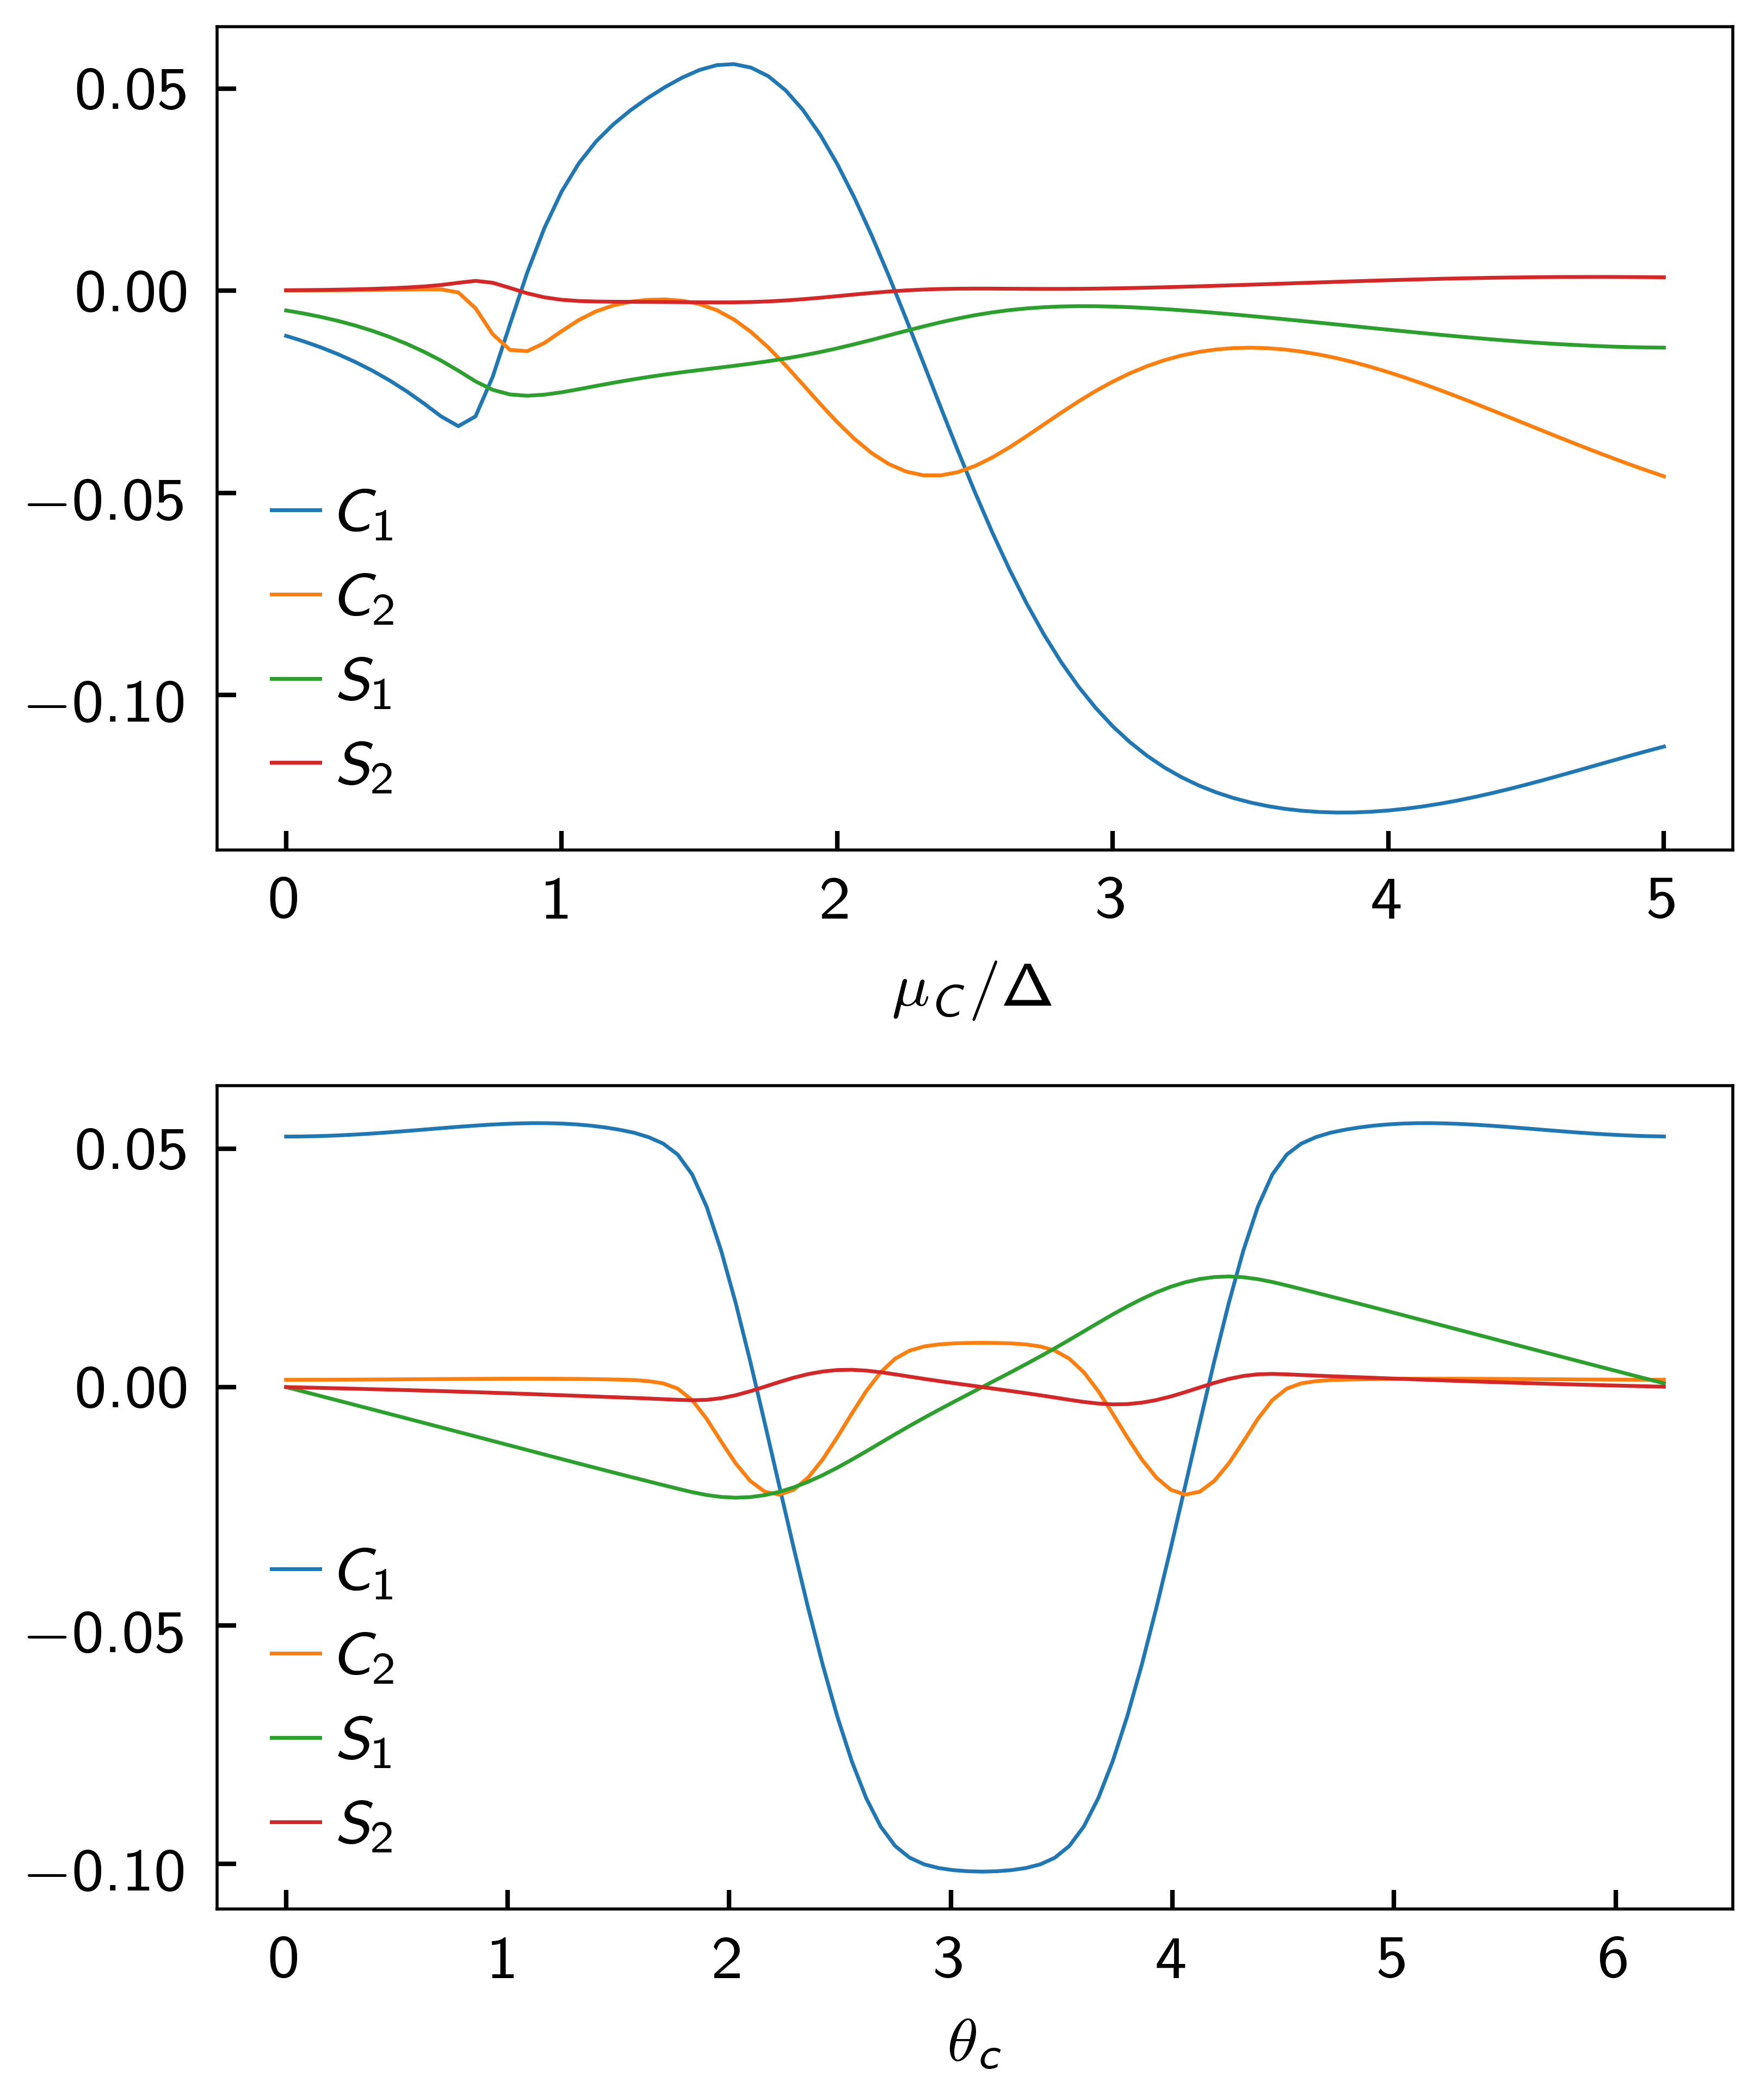

In [25]:
fig, (ax1, ax2) = plt.subplots(figsize=(3.375, 4), nrows=2)

ax1.plot(b[0, :] / b_scale, cF_k[a_idx, :, 1] / Delta_0, "-", label=r"$C_1$")
ax1.plot(b[0, :] / b_scale, cF_k[a_idx, :, 2] / Delta_0, "-", label=r"$C_2$")
ax1.plot(b[0, :] / b_scale, sF_k[a_idx, :, 1] / Delta_0, "-", label=r"$S_1$")
ax1.plot(b[0, :] / b_scale, sF_k[a_idx, :, 2] / Delta_0, "-", label=r"$S_2$")
ax1.legend()
ax1.set_xlabel(b_label)

ax2.plot(a[:, 0] / a_scale, cF_k[:, b_idx, 1] / Delta_0, "-", label=r"$C_1$")
ax2.plot(a[:, 0] / a_scale, cF_k[:, b_idx, 2] / Delta_0, "-", label=r"$C_2$")
ax2.plot(a[:, 0] / a_scale, sF_k[:, b_idx, 1] / Delta_0, "-", label=r"$S_1$")
ax2.plot(a[:, 0] / a_scale, sF_k[:, b_idx, 2] / Delta_0, "-", label=r"$S_2$")
ax2.legend()
ax2.set_xlabel(a_label)

fig.tight_layout()

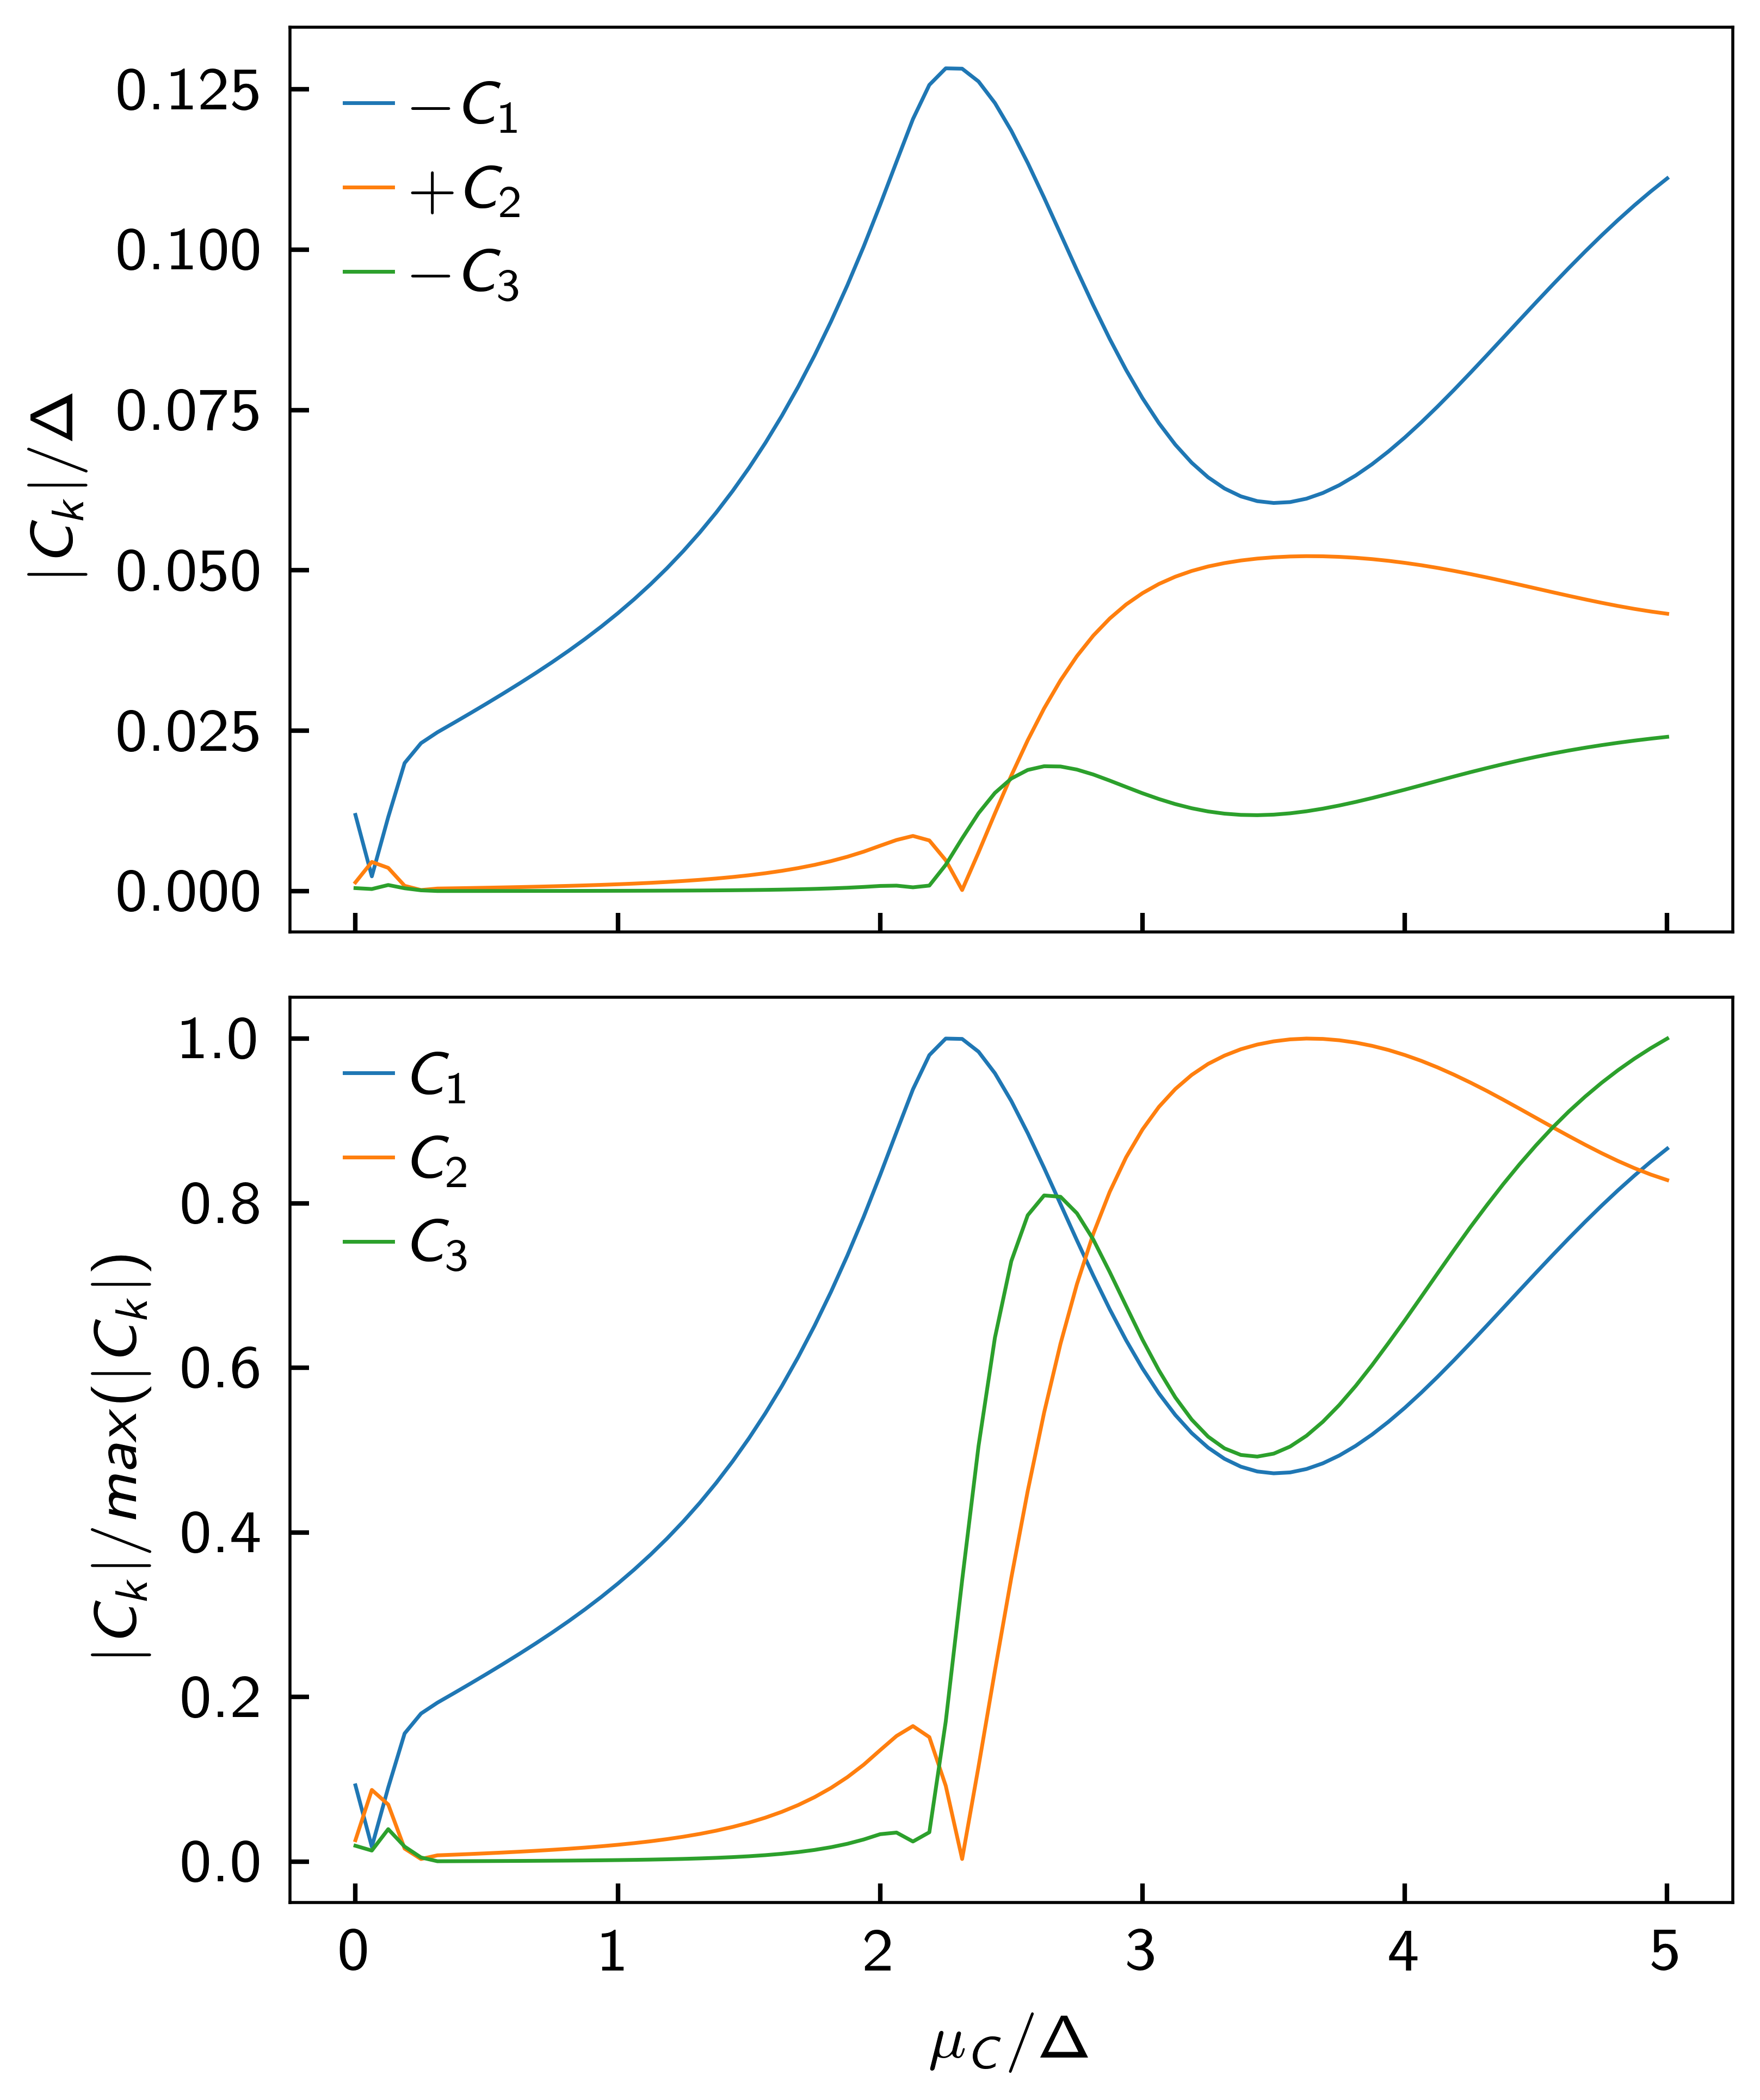

In [26]:
fig, (ax1, ax2) = plt.subplots(figsize=(3.375, 4), nrows=2, sharex=True)

ax1.plot(b[0, :] / b_scale, np.abs(cF_k[5, :, 1]) / Delta_0, "-", label=r"$-C_1$")
ax1.plot(b[0, :] / b_scale, np.abs(cF_k[5, :, 2]) / Delta_0, "-", label=r"$+C_2$")
ax1.plot(b[0, :] / b_scale, np.abs(cF_k[5, :, 3]) / Delta_0, "-", label=r"$-C_3$")
ax1.legend()

ax2.plot(
    b[0, :] / b_scale,
    np.abs(cF_k[5, :, 1] / np.max(np.abs(cF_k[5, :, 1]))),
    "-",
    label="$C_1$",
)
ax2.plot(
    b[0, :] / b_scale,
    np.abs(cF_k[5, :, 2] / np.max(np.abs(cF_k[5, :, 2]))),
    "-",
    label="$C_2$",
)
ax2.plot(
    b[0, :] / b_scale,
    np.abs(cF_k[5, :, 3] / np.max(np.abs(cF_k[5, :, 3]))),
    "-",
    label="$C_3$",
)
ax2.legend()

ax1.set_ylabel(r"$|C_k| / \Delta$")
ax2.set_ylabel(r"$|C_k| / max(|C_k|)$")
ax2.set_xlabel(b_label)

fig.tight_layout()

In [27]:
b_coord = 50
print(b[0, b_coord] / b_scale)

3.125


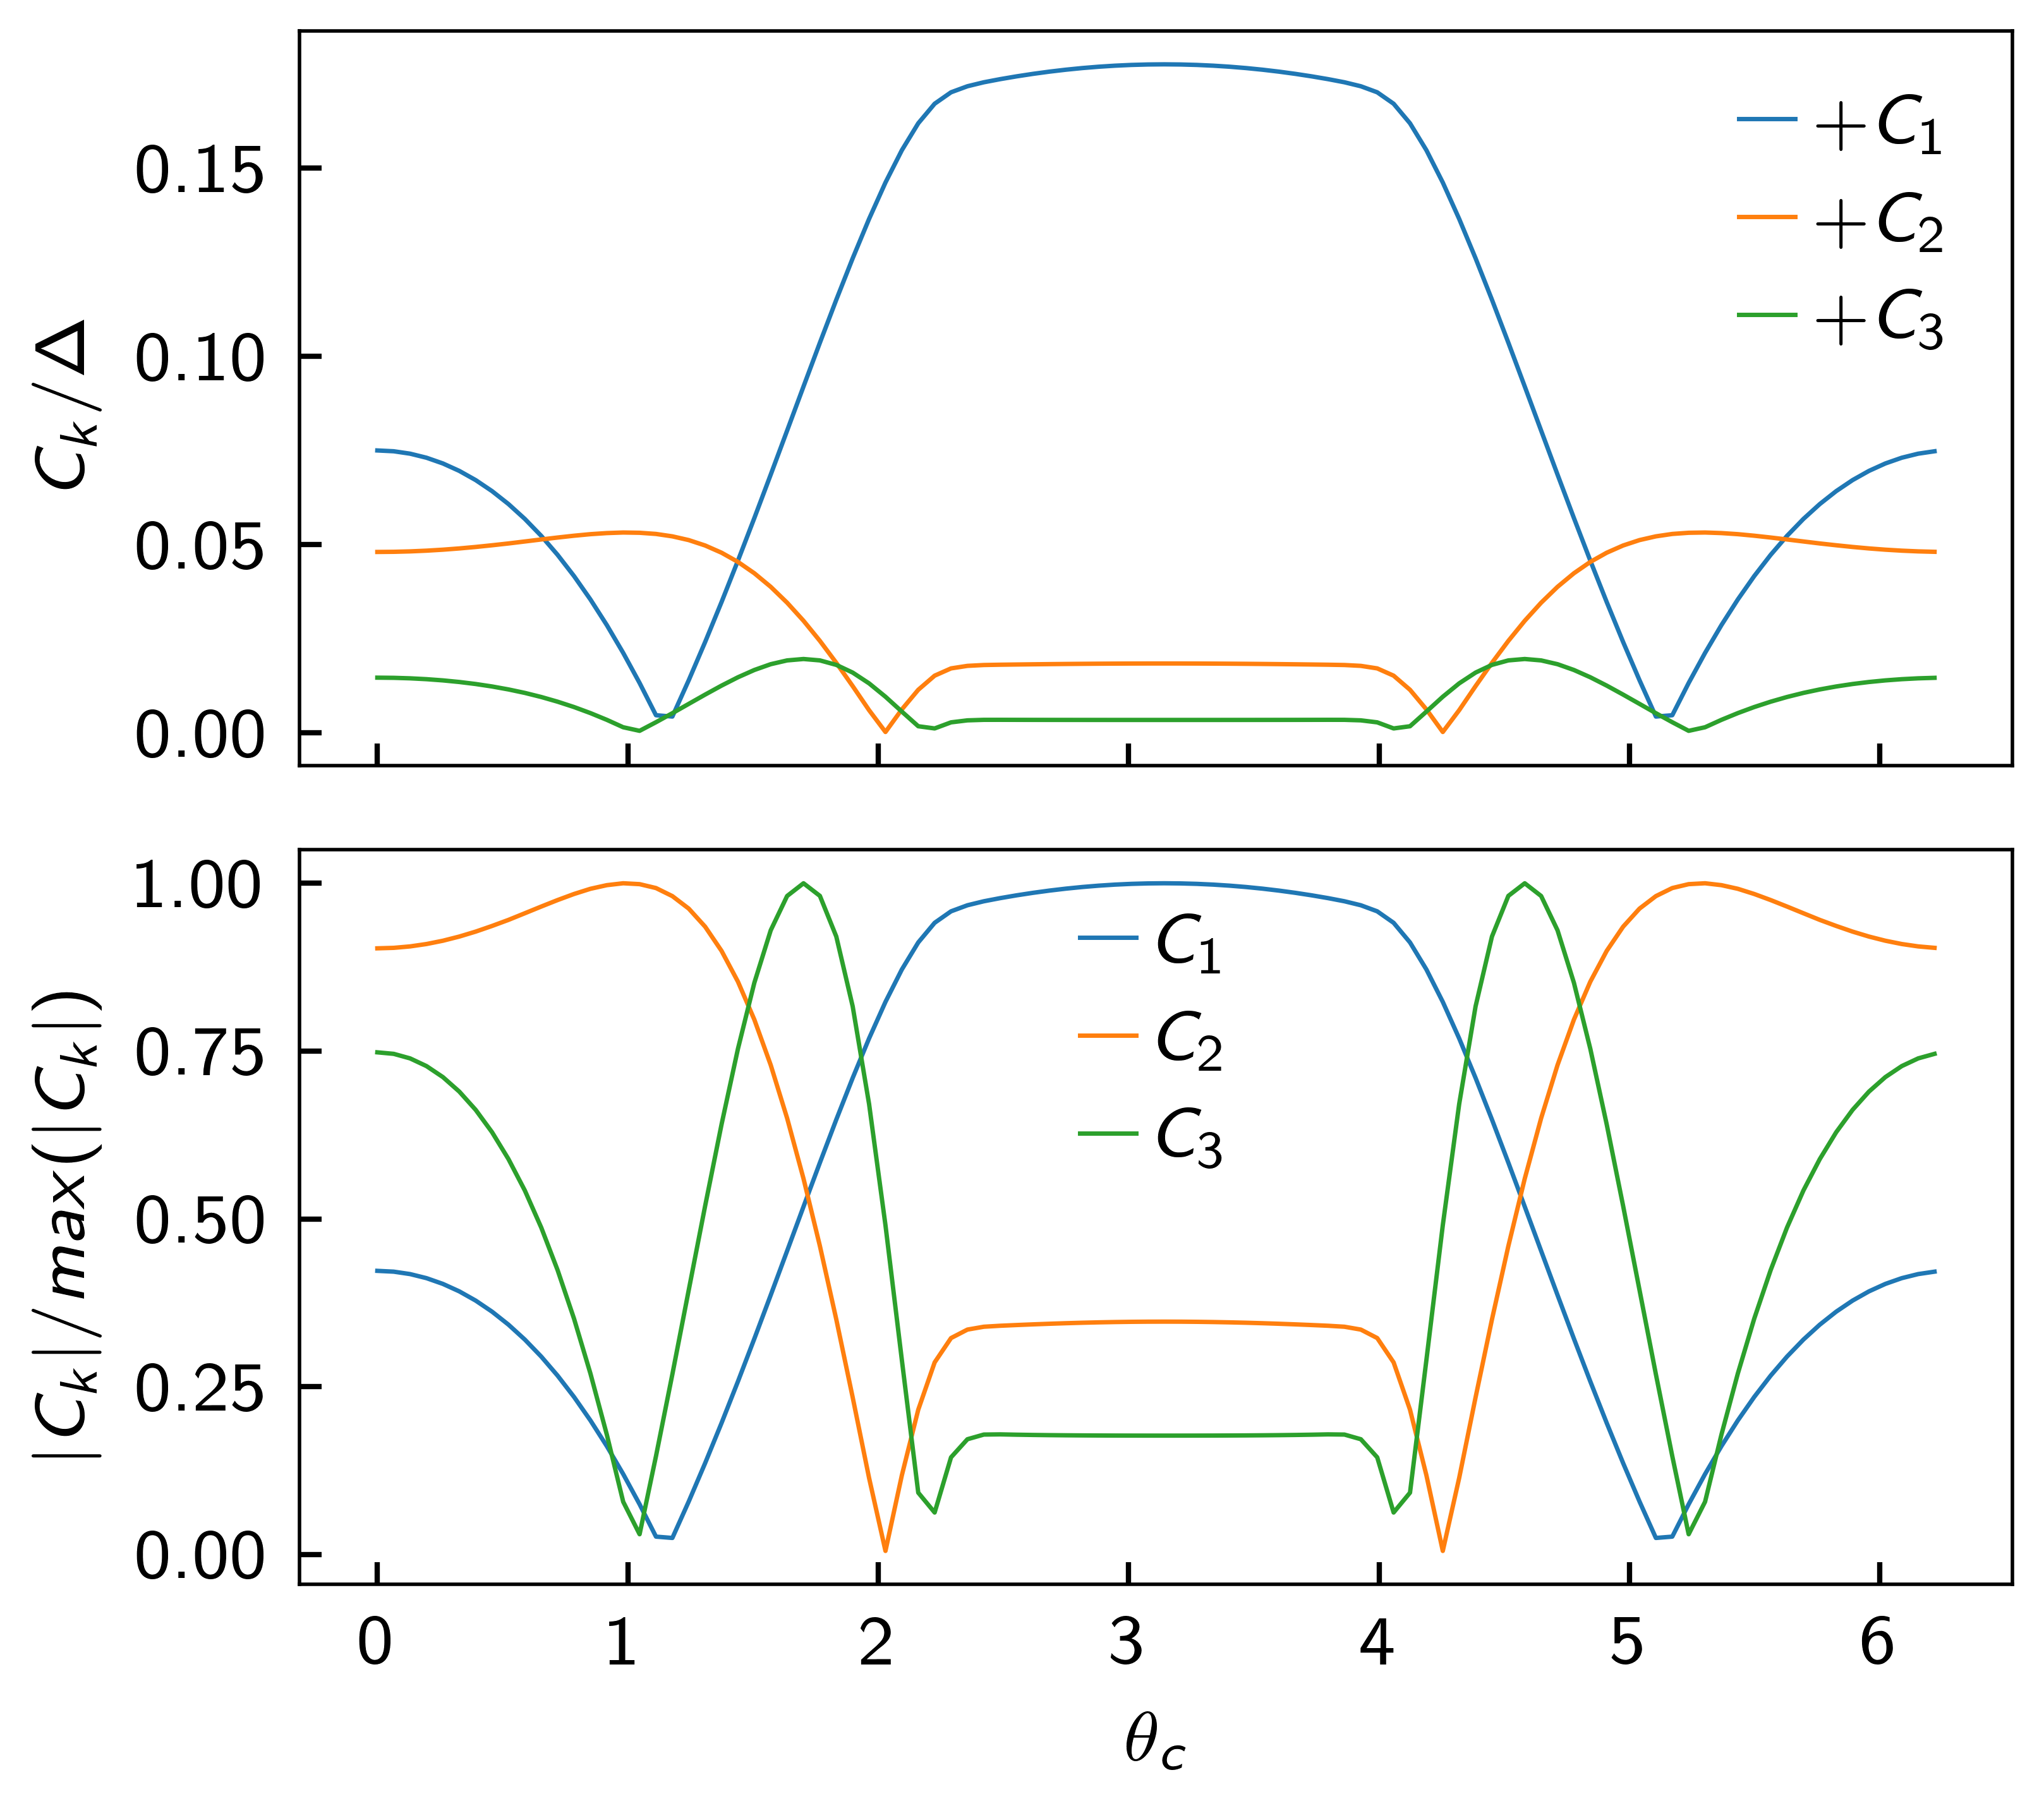

In [28]:
fig, (ax1, ax2) = plt.subplots(figsize=(3.375, 3), nrows=2, sharex=True)

ax1.plot(
    a[:, b_coord] / a_scale, np.abs(cF_k[:, b_coord, 1]) / Delta_0, "-", label=r"$+C_1$"
)
ax1.plot(
    a[:, b_coord] / a_scale, np.abs(cF_k[:, b_coord, 2]) / Delta_0, "-", label=r"$+C_2$"
)
ax1.plot(
    a[:, b_coord] / a_scale, np.abs(cF_k[:, b_coord, 3]) / Delta_0, "-", label=r"$+C_3$"
)
ax1.legend()

ax2.plot(
    a[:, b_coord] / a_scale,
    np.abs(cF_k[:, b_coord, 1] / np.max(np.abs(cF_k[:, b_coord, 1]))),
    "-",
    label="$C_1$",
)
ax2.plot(
    a[:, b_coord] / a_scale,
    np.abs(cF_k[:, b_coord, 2] / np.max(np.abs(cF_k[:, b_coord, 2]))),
    "-",
    label="$C_2$",
)
ax2.plot(
    a[:, b_coord] / a_scale,
    np.abs(cF_k[:, b_coord, 3] / np.max(np.abs(cF_k[:, b_coord, 3]))),
    "-",
    label="$C_3$",
)
ax2.legend()

ax1.set_ylabel(r"$C_k / \Delta$")
ax2.set_ylabel(r"$|C_k| / max(|C_k|)$")
ax2.set_xlabel(a_label)

fig.tight_layout()

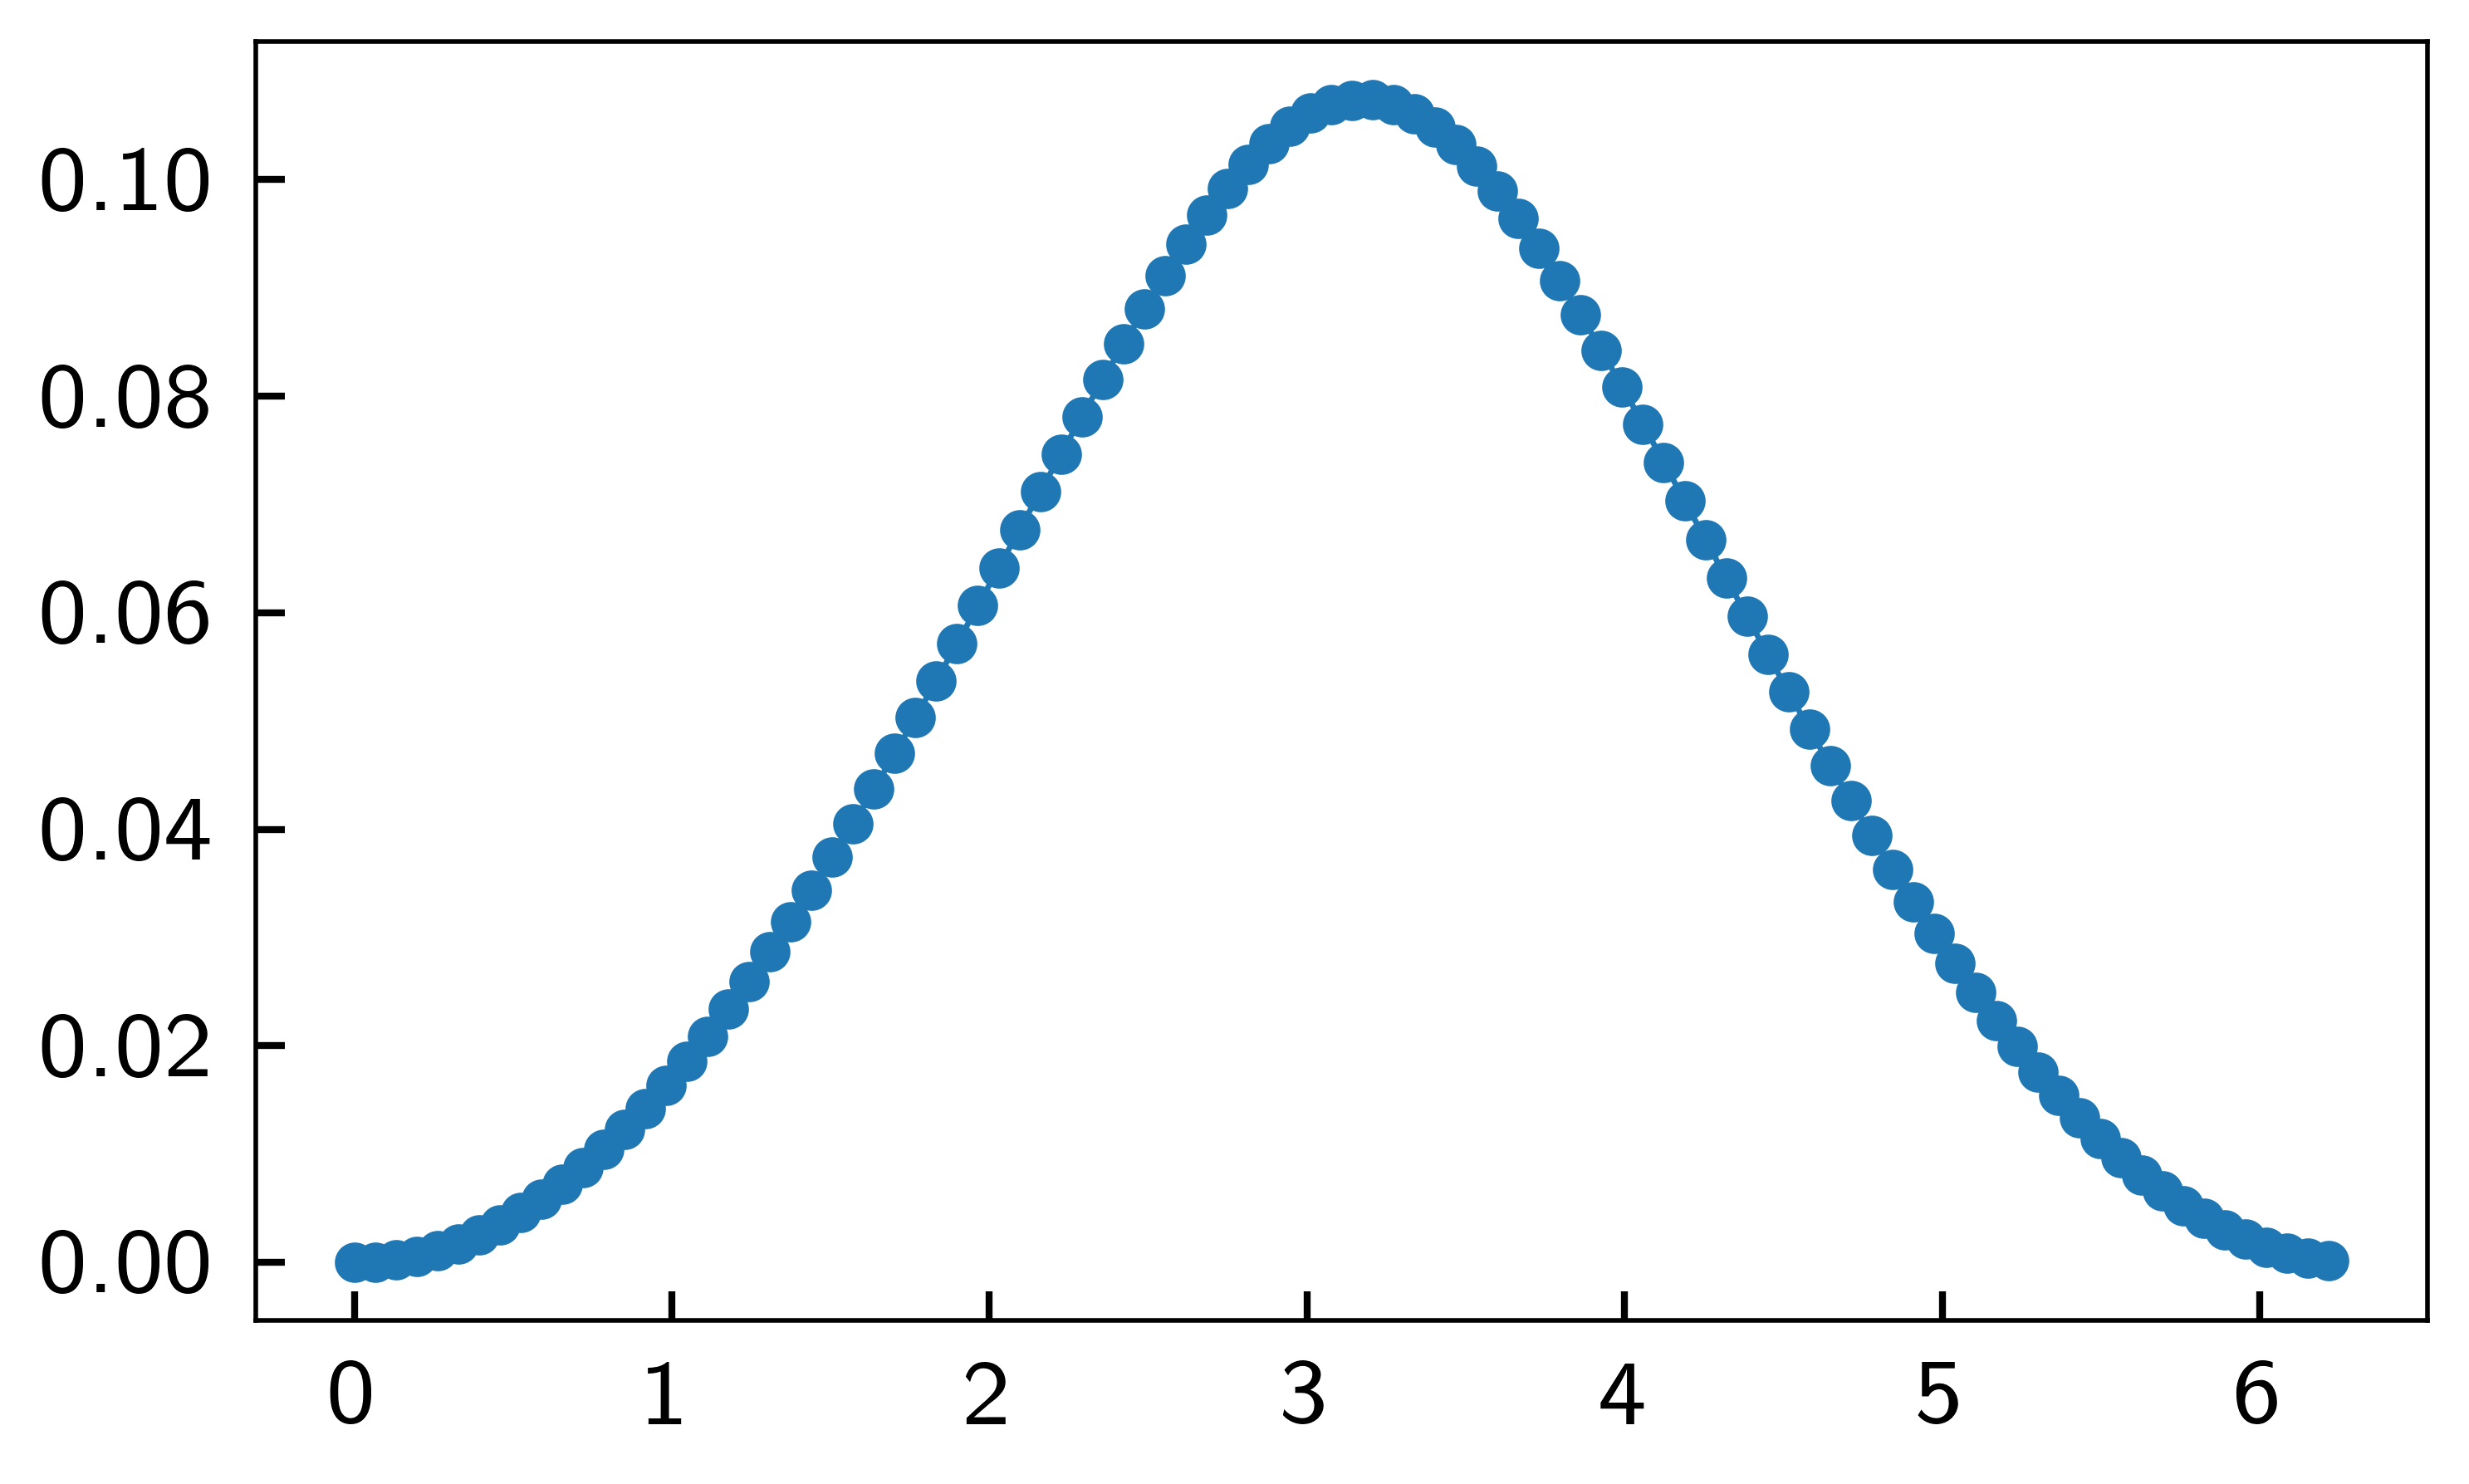

In [29]:
a_idx = 40
b_idx = 70

plt.plot(theta_ax, F[a_idx, b_idx] - F[a_idx, b_idx, 0])

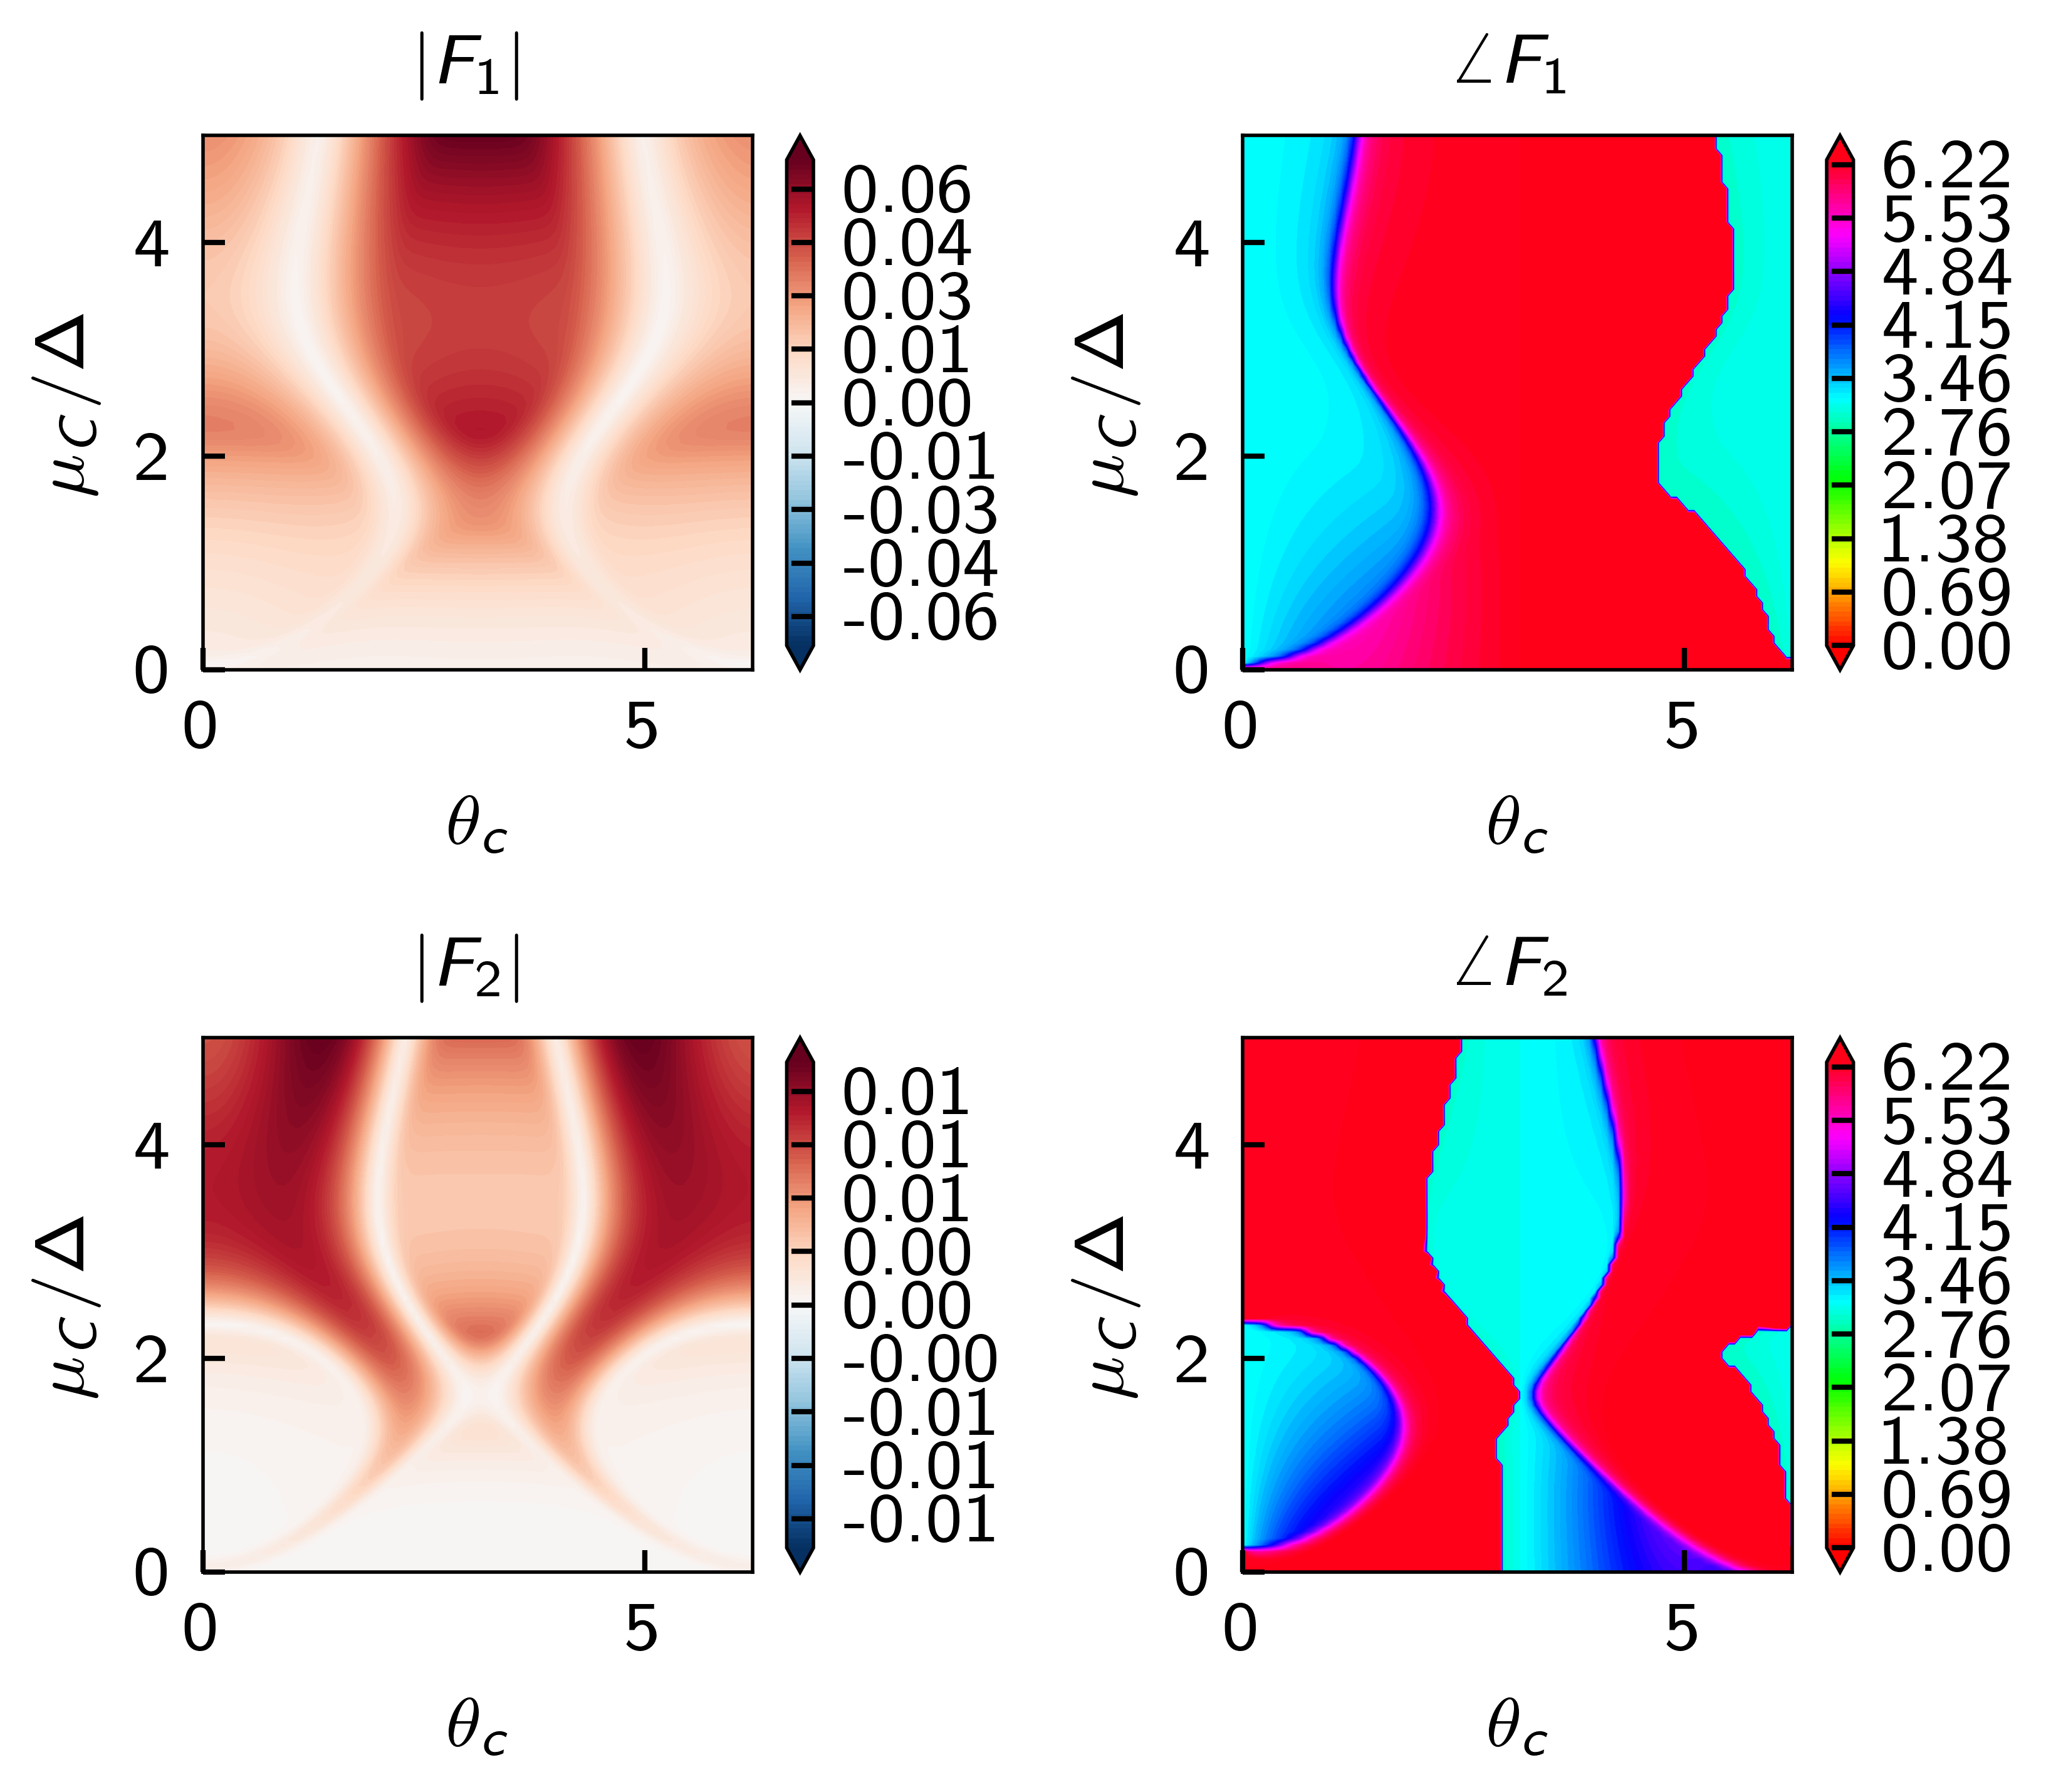

In [30]:
what1 = np.abs(F_k[..., 1])
what2 = np.mod(np.angle(F_k[..., 1]) + 0.2, (2 * np.pi)) - 0.2 + np.pi
what3 = np.abs(F_k[..., 2])
what4 = np.mod(np.angle(F_k[..., 2]) + 0.2, (2 * np.pi)) - 0.2 + np.pi
levels1 = np.linspace(-1, 1, 101) * np.max(np.abs(what1))
levels2 = np.linspace(0, 2, 101) * np.pi
levels3 = np.linspace(-1, 1, 101) * np.max(np.abs(what3))
levels4 = np.linspace(0, 2, 101) * np.pi
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(3.4, 3))

ax1.set_rasterization_zorder(0)
ax2.set_rasterization_zorder(0)
ax3.set_rasterization_zorder(0)
ax4.set_rasterization_zorder(0)

ax1.set_xlabel(a_label)
ax1.set_ylabel(b_label)

ax2.set_xlabel(a_label)
ax2.set_ylabel(b_label)

ax3.set_xlabel(a_label)
ax3.set_ylabel(b_label)

ax4.set_xlabel(a_label)
ax4.set_ylabel(b_label)

im1 = ax1.contourf(
    a / a_scale,
    b / b_scale,
    what1,
    levels=levels1,
    cmap="RdBu_r",
    zorder=-30,
    extend="both",
)
fig.colorbar(im1, ax=ax1, format="%3.2f")
ax1.set_title(r"$\vert F_1 \vert$")

im2 = ax2.contourf(
    a / a_scale,
    b / b_scale,
    what2,
    levels=levels2,
    cmap="hsv",
    zorder=-30,
    extend="both",
)
fig.colorbar(im2, ax=ax2, format="%3.2f")
ax2.set_title(r"$\angle F_1 $")

im3 = ax3.contourf(
    a / a_scale,
    b / b_scale,
    what3,
    levels=levels3,
    cmap="RdBu_r",
    zorder=-30,
    extend="both",
)
fig.colorbar(im3, ax=ax3, format="%3.2f")
ax3.set_title(r"$\vert F_2 \vert$")


im4 = ax4.contourf(
    a / a_scale,
    b / b_scale,
    what4,
    levels=levels4,
    cmap="hsv",
    zorder=-30,
    extend="both",
)
fig.colorbar(im4, ax=ax4, format="%3.2f")
ax4.set_title(r"$\angle F_2 $")

# ax3.scatter(coords[:, 0], coords[:, 1], c=colors, zorder=10, marker="x")

fig.tight_layout()
fig.savefig(f"./output/{simname}/plots/{simname}_FT_ma.svg")

In [31]:
## phi_0 VERSION

idx = np.zeros((2, 4), dtype=int)
idx[0] = np.round((coords[0] - a_ax[0]) / (a_ax[1] - a_ax[0])).astype(int)
idx[1] = np.round((coords[1] - b_ax[0]) / (b_ax[1] - b_ax[0])).astype(int)


colors = [
    "xkcd:bright sky blue",
    "xkcd:cobalt blue",
    "xkcd:bright purple",
    "xkcd:bordeaux",
]
# colors = ["red", "red", "red", "red"]


# idx = np.round(((idx + 4) * 101 / 8)).astype(int)


fig, (ax1, ax2, ax3) = plt.subplots(
    dpi=1000, figsize=(3.375 * 1.8, 3.375 * 0.5), ncols=3
)

levels = np.linspace(0, 2 * np.pi, 64)

im = ax1.contourf(
    a / a_scale, b / b_scale, pdm, levels=levels, cmap="twilight", zorder=-30
)

ax1.set_xlabel(a_label)
ax1.set_ylabel(b_label)

if gap_inv_lines:
    ax1.hlines(
        [-1, +1],
        a_ax.min(),
        a_ax.max(),
        color="k",
        linestyles="dashed",
        linewidths=0.75,
    )
#    ax1.vlines([-1, +1], b_ax.min(), b_ax.max(), color="k", linestyles="dashed", linewidths=0.75)

# ax1.set_xticks([0, np.pi, 2 * np.pi])
# ax1.set_xticklabels([0, r"$\pi$", r"$2\pi$"])

cbar = fig.colorbar(im, ax=ax1)
cbar.set_ticks([0, np.pi, 2 * np.pi])
cbar.set_ticklabels([0, r"$\pi$", r"$2\pi$"])
cbar.ax.tick_params(length=0)

# mag = I_c / np.max(I_c)
# rgba = np.zeros((a_N, b_N, 4))
# rgba[:, :, 0] = 0.15
# rgba[:, :, 1] = 0.15
# rgba[:, :, 2] = 0.15
# rgba[:, :, 3] = ((1 - mag.T))

# ax.imshow(
#     rgba,
#     origin="lower",
#     interpolation="nearest",
#     extent=np.array([a_ax.min(), a_ax.max(), b_ax.min(), b_ax.max()]) / a_scale,
#     zorder=-20,
# )

# ax.set_aspect('auto')


ax1.set_rasterization_zorder(-10)

#####

levels = np.linspace(-maxI, maxI, 100)
im = ax2.contourf(
    a / a_scale, b / b_scale, I_c, levels=levels, cmap="RdBu_r", zorder=-30
)
cbar = fig.colorbar(im, ax=ax2)
ax2.set_xlabel(a_label)
ax2.set_ylabel(b_label)

if gap_inv_lines:
    ax2.hlines(
        [-1, +1],
        a_ax.min(),
        a_ax.max(),
        color="k",
        linestyles="dashed",
        linewidths=0.75,
    )
#    ax2.vlines([-1, +1], b_ax.min(), b_ax.max(), color="k", linestyles="dashed", linewidths=0.75)

cbar.set_ticks([levels[0], 0, levels[-1]])
ax2.set_title(r"$I_c$ [nA]")


# ax2.set_xticks([0, np.pi, 2 * np.pi])
# ax2.set_xticklabels([0, r"$\pi$", r"$2\pi$"])

ax2.set_rasterization_zorder(-10)

###############################

# ax1.scatter(a_ax[idx[0]], b_ax[idx[1]], c=colors, zorder=10, marker="x")
# ax2.scatter(a_ax[idx[0]], b_ax[idx[1]], c=colors, zorder=10, marker="x")
# ax3.plot(theta_ax, I[idx[0, 0], idx[1, 0]], "-", c=colors[0])
# ax3.plot(theta_ax, I[idx[0, 1], idx[1, 1]], "-", c=colors[1])
# ax3.plot(theta_ax, I[idx[0, 2], idx[1, 2]], "-", c=colors[2])
# ax3.plot(theta_ax, I[idx[0, 3], idx[1, 3]], "-", c=colors[3])
# ax3.set_xlabel(r"$\phi$")
# ax3.set_ylabel(r"$I$ [nA]")

# ax3.set_xticks([0, np.pi, 2 * np.pi])
# ax3.set_xticklabels([r"$0$", r"$\pi$", r"$2\pi$"])

# ax3.set_xlim(0, 2 * np.pi)

fig.tight_layout()
fig.savefig(f"./output/{simname}/plots/{simname}_complete_phi0.svg")

ValueError: could not broadcast input array from shape (2,) into shape (4,)

NameError: name 'maxI' is not defined

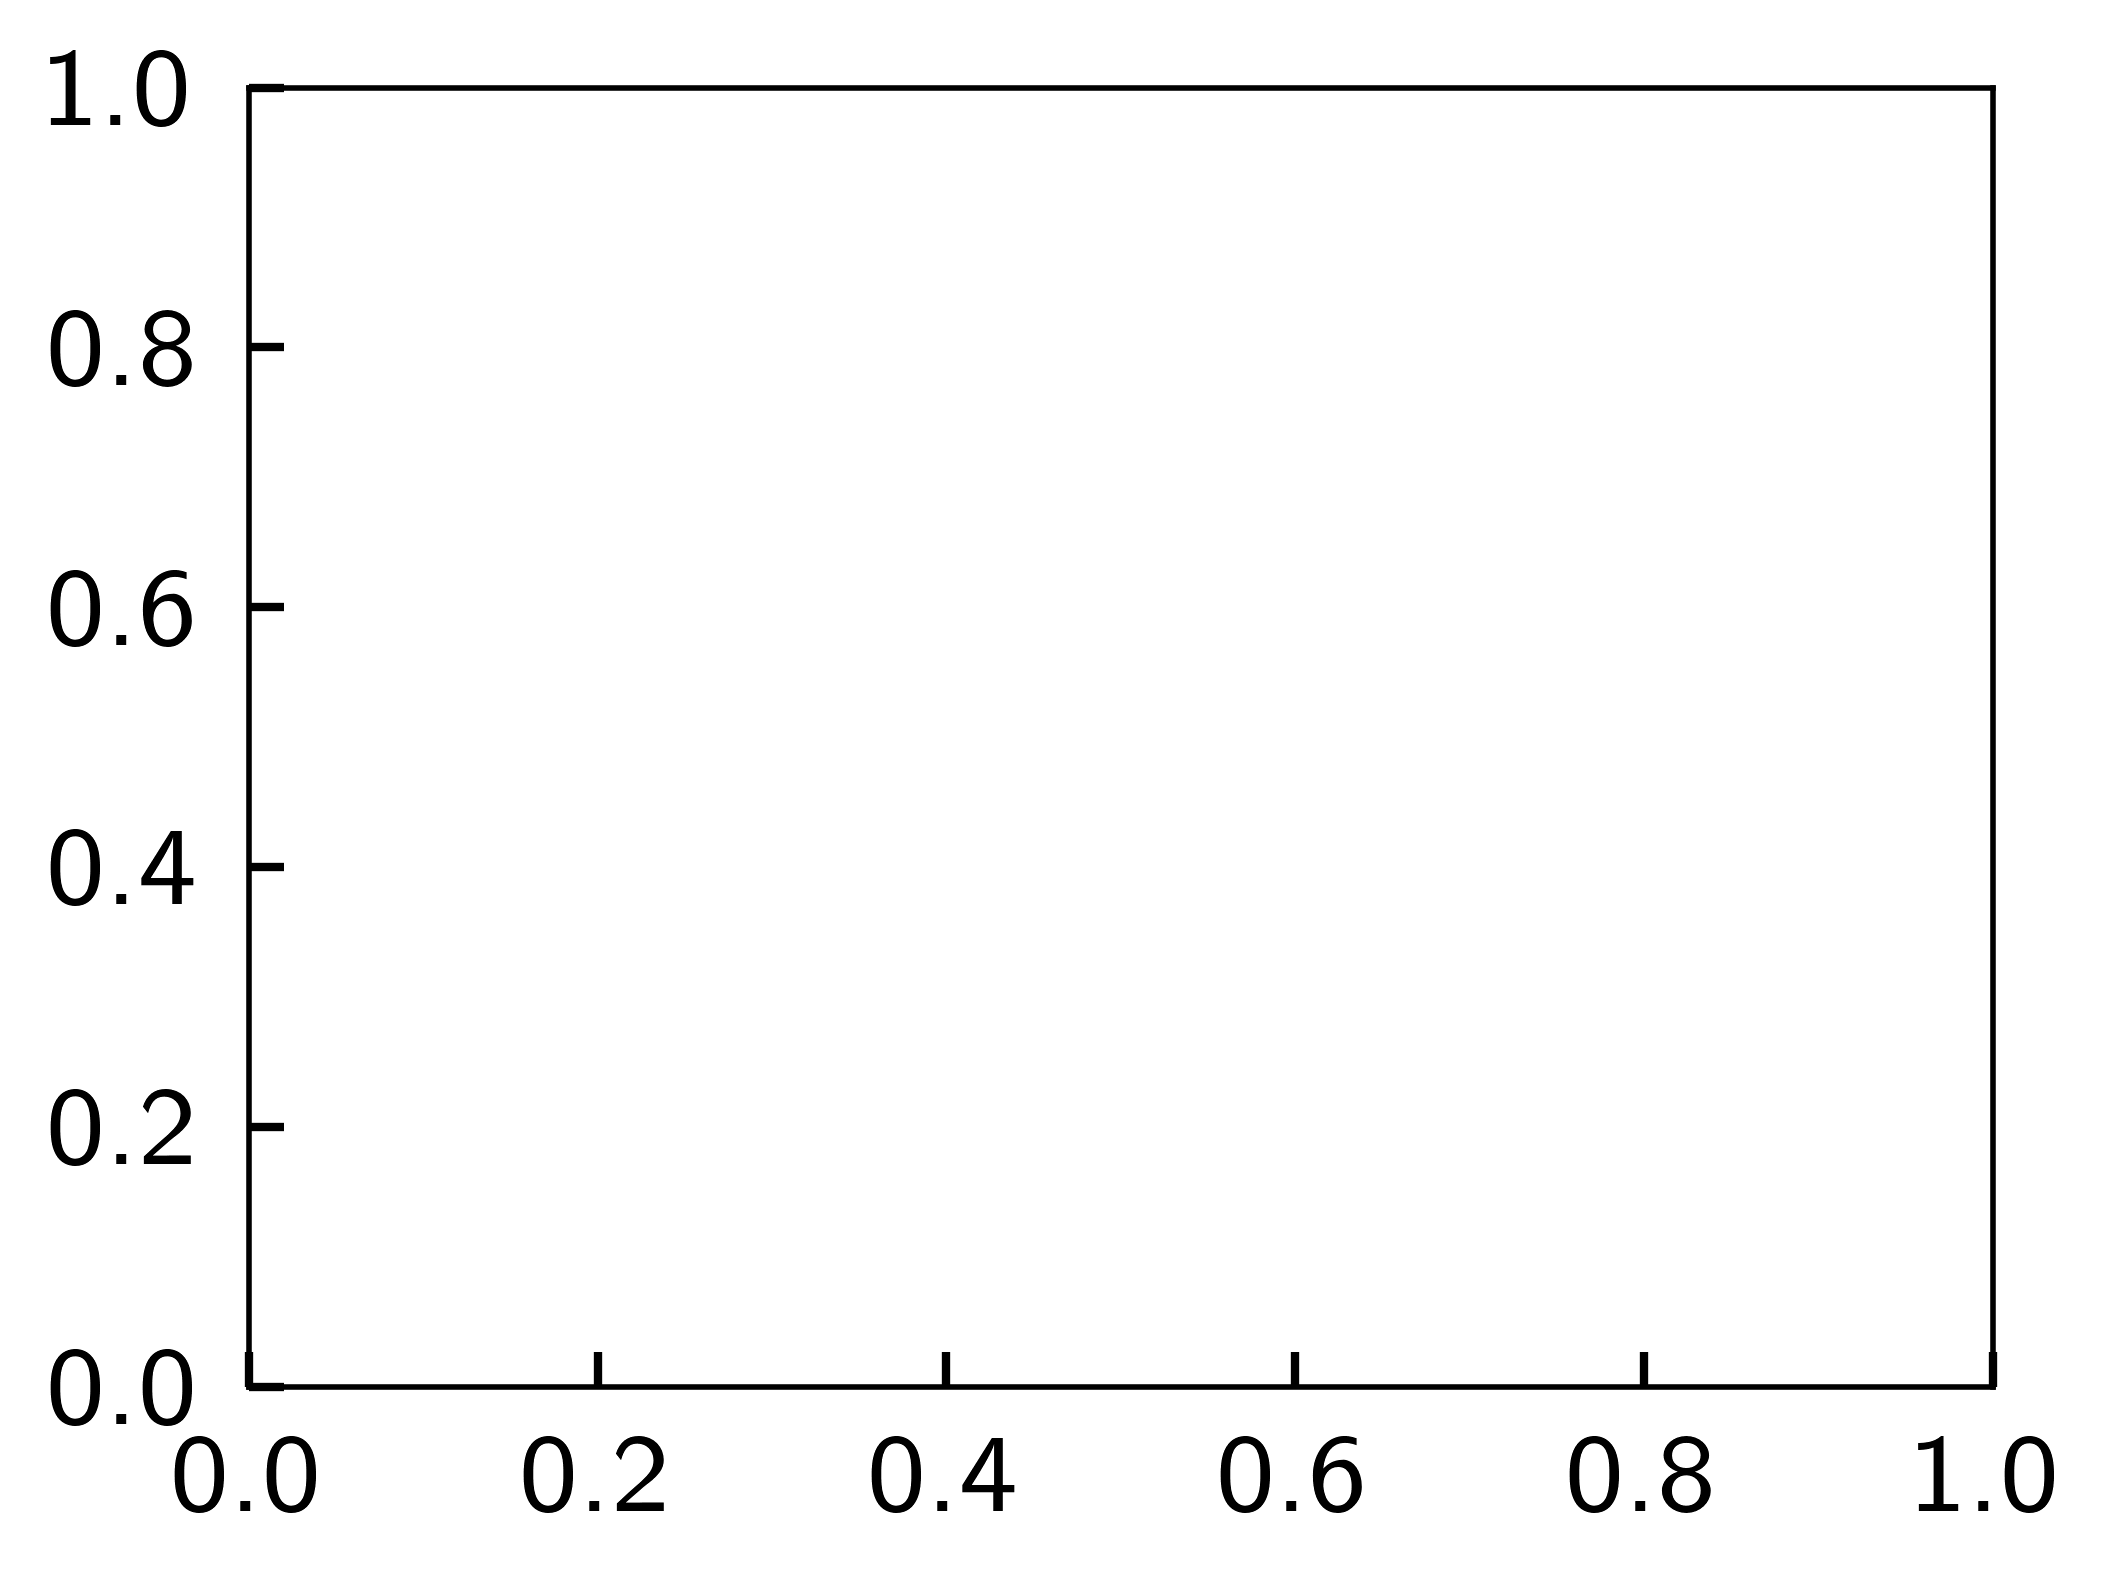

In [32]:
fig, ax = plt.subplots(dpi=1000, figsize=(3.375 * 2 / 3, 3.375 * 0.5))
levels = np.linspace(-maxI, maxI, 100)
im = ax.contourf(a, b, I[:, :, theta_N // 4], levels=levels, cmap="RdBu_r", zorder=-30)
cbar = fig.colorbar(im, ax=ax)
ax.set_ylabel(b_label)
ax.set_xlabel(a_label)
# ax.set_ylabel(r"$\mu_\mathrm{w}$")

# ax.set_xticks([-2, 0, 2])
# ax.set_yticks([-2, 0, 2])

# ax.hlines([-1, +1], -4, 4, color="k", linestyles="dashed", linewidths=0.75)
# ax.vlines([-1, +1], -4, 4, color="k", linestyles="dashed", linewidths=0.75)

cbar.set_ticks([levels[0], 0, levels[-1]])
cbar.set_label(r"$I(\phi=\pi/4)$ [nA]")

# ax.set_ylim(-5, 10)
# ax.set_xlim(0, 2)

ax.set_rasterization_zorder(-10)

fig.tight_layout()
# fig.savefig(f"./plots/{dp['simname']}_Iatpih.svg")

In [ ]:
fig, ax = plt.subplots(dpi=1000, figsize=(3.375 * 2 / 3, 3.375 * 0.5))

im = ax.contourf(
    theta_ax, a_ax / a_scale, I[:, b_N // 2, :], cmap="RdBu", levels=levels
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$V_\nu/\Delta_0$")
ax.set_xticks([0, np.pi, 2 * np.pi])
ax.set_xticklabels([r"$0$", r"$\pi$", r"$2\pi$"])

cbar = fig.colorbar(im)
cbar.set_ticks([levels[0], 0, levels[-1]])
cbar.set_label("$I$ [nA]")

ax.set_rasterization_zorder(-10)

fig.tight_layout()
fig.savefig(f"./plots/{dp['simname']}_CPRp.svg")

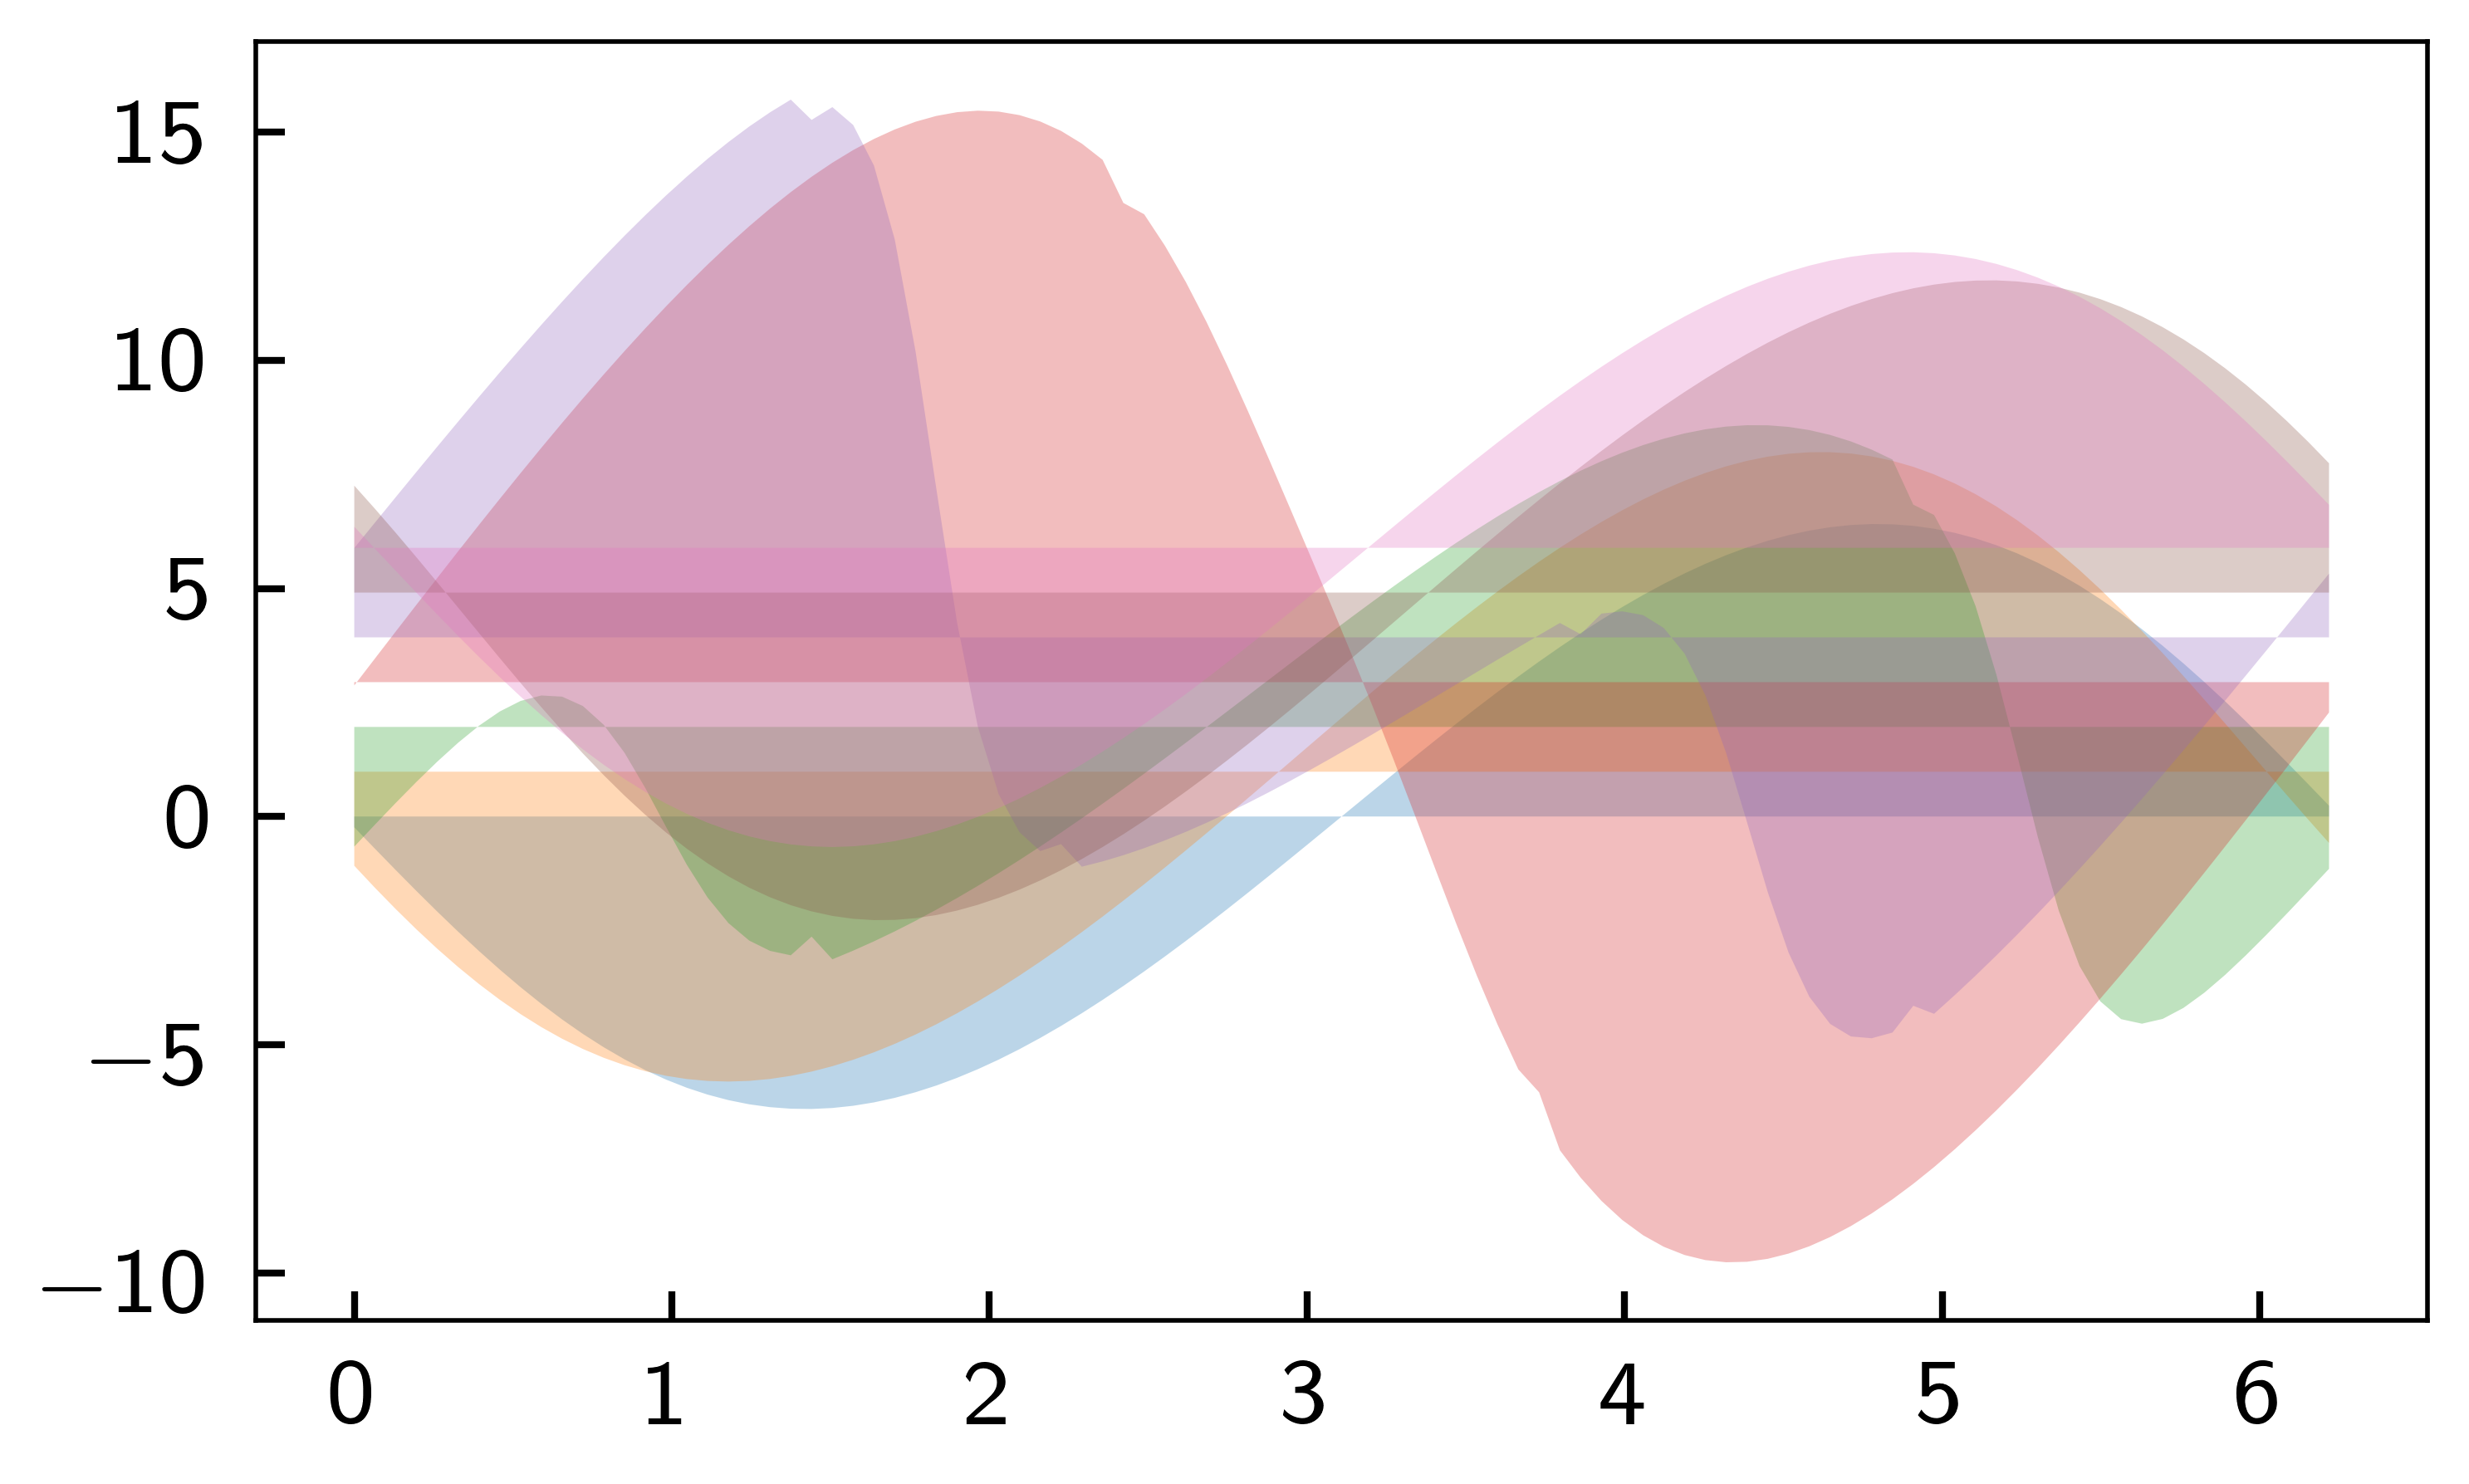

In [33]:
fig, ax = plt.subplots()


y = I[::15, 20].as_numpy().astype(float)
x_ax = theta_ax

z_ax = a_ax[::15]
N, y_len = y.shape

for n in range(N):
    ax.fill_between(x=x_ax, y1=z_ax[n] + y[n], y2=z_ax[n], alpha=0.3, linestyle="-")